## Setup

In [ ]:
import collections
import copy
import json
import jsonlines
import math
from pathlib import Path
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import torch
import torchinfo
import torch_geometric as torch_geo
from tqdm import tqdm
import transformers

from libs.pointnet2.pointnet2_modules import PointnetSAModule

In [2]:
print(torch.cuda.is_available())

True


## Config

In [ ]:
NUM_WORKERS = 8
SEED_RNG = 42
PATH_DIR_DATA = "/home/user/karacora/data"
PATH_DIR_WEIGHTS = "/home/karacora/repos/visual-grounding-3d-gae/resources/weights"

In [4]:
def init_rng():
    random.seed(SEED_RNG)
    np.random.seed(SEED_RNG)
    torch.manual_seed(SEED_RNG)
    torch_geo.seed_everything(SEED_RNG)


init_rng()

## Experiment config

In [5]:
# Data
NAME_DIR_DATASET = "ScanNet"
USE_BACKGROUND = False
USE_SR3D_PLUS = True
NUM_POINTS_SUBSAMPLE = 1024
PROB_AUGMENTATION_ROTATION_SCENE = 1.0
USE_AXIS_Z = True
USE_AXIS_ALIGNMENT = True
PROB_AUGMENTATION_ROTATION_OBJECTS = 0.05
PROB_AUGMENTATION_JITTER_COLOR = 1.0
SCALE_JITTER_COLOR = 0.05
PROB_AUGMENTATION_TRANSLATION_OBJECTS = 1.0
SCALE_TRANSLATION_OBJECTS = 0.05
MAX_DISTANCE = 2.0
NUM_NEIGHBORS = 5

# Model
MAX_NUM_TOKENS = 50
NUM_CHANNELS_IN = 768
NUMS_CHANNELS_OUT_ENCODER_POSITION = 768
NUMS_CHANNELS_OUT_PROJECTOR_CLASS = 768
NUM_CHANNELS_HIDDEN = 768
NUMS_CHANNELS_HIDDEN_ENCODER_POSITION = (192, 384)
NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS = []
NUMS_CHANNELS_HIDDEN_ENCODER_GNN = (768, 768, 768, 768)
NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE = (768,)
NUMS_CHANNELS_HIDDEN_REFFERAL = (768,)
NUMS_CHANNELS_HIDDEN_HEAD = (768,)
NUM_LAYERS_REFERRAL = 4
PROB_DROPOUT_ENCODER_POINTS = 0.2
PROB_DROPOUT_ENCODER_POSITION = 0.2
PROB_DROPOUT_PROJECTOR_CLASS = 0.2
PROB_DROPOUT_ENCODER_GNN = 0.1
PROB_DROPOUT_PROJECTOR_LANGUAGE = 0.1
PROB_DROPOUT_REFERRAL = 0.1
PROB_DROPOUT_HEAD = 0.3
NAME_LAYER_CONV = "GATConv"
NUM_SAMPLES_NEIGHBORS = 5
USE_RESIDUAL = True
USE_CONCAT = False
MODE_JK = "max"
USE_NORM_PAIR = True
NUM_HEADS = 12
USE_ENCODING_POSITIONS = True


# Training
NUM_ITEMS_BATCH = 128
NUM_EPOCHS_PRETRAINING = 100
NUM_EPOCHS = 50
NUM_EPOCHS_WARMUP = 3
RATE_LEARNING = 1e-4
GAMMA_DECAY_LR = 0.95
GAMMA_DECAY_LR_PRETRAINING = 0.99
BETA1 = 0.9
BETA2 = 0.98
RATE_DECAY_WEIGHT = 1e-2
CRITERION_WEIGHTS = (1.0, 1.0, 1.0, 1.0, 0.1)
NUM_STEPS_LOGGING = 5
USE_EARLY_STOPPING = True
PATIENCE_EARLY_STOPPING = 5
PATIENCE_EARLY_STOPPING_PRETRAINING = 10
USE_CLIP_GRAD = True
MAX_NORM_GRAD = 1.0

## Dataset

In [6]:
def subsample_points(points, num_points):
    num_points_original = len(points)
    use_replace = num_points_original < num_points
    idxs_points = np.random.choice(num_points_original, size=num_points, replace=use_replace)
    points = points[idxs_points]

    return points


def points_to_tensor_scan_subsample(scan, num_points):
    for i in range(len(scan["points_colored_instance"])):
        scan["points_colored_instance"][i] = subsample_points(scan["points_colored_instance"][i], num_points)

    scan["points_colored_instance"] = torch.stack(scan["points_colored_instance"], dim=0)

    return scan


class PointsToTensorScanSubsample(torch.nn.Module):
    def __init__(self, num_points):
        super().__init__()

        self.num_points = num_points

    def forward(self, scan):
        scan_transformed = points_to_tensor_scan_subsample(scan, self.num_points)
        return scan_transformed

In [7]:
def sample_rotation(use_axis_z=False, use_axis_alignment=False):
    if not use_axis_alignment:
        if not use_axis_z:
            vec_q = np.random.normal(size=4)
            vec_q /= np.linalg.norm(vec_q)
            rotation = sp.spatial.transform.Rotation.from_quat(vec_q)
        else:
            angle = np.random.uniform(-np.pi, np.pi)
            rotation = sp.spatial.transform.Rotation.from_euler("z", angle, degrees=False)
    else:
        angles_axis_aligned = np.array([0.0, 0.25, 0.5, 0.75]) * 2.0 * np.pi
        if not use_axis_z:
            angle_x = np.random.choice(angles_axis_aligned)
            angle_y = np.random.choice(angles_axis_aligned)
            angle_z = np.random.choice(angles_axis_aligned)
            rotation = sp.spatial.transform.Rotation.from_euler("xyz", [angle_x, angle_y, angle_z], degrees=False)
        else:
            angle = np.random.choice(angles_axis_aligned)
            rotation = sp.spatial.transform.Rotation.from_euler("z", angle, degrees=False)

    mat_r = torch.from_numpy(rotation.as_matrix())

    return mat_r


def rotate_scan(scan, use_axis_z=False, use_axis_alignment=False):
    mat_r = sample_rotation(use_axis_z=use_axis_z, use_axis_alignment=use_axis_alignment)

    scan["points_colored_instance"][:, :, :3] = scan["points_colored_instance"][:, :, :3] @ mat_r.T.float()

    return scan


class RotationScan(torch.nn.Module):
    def __init__(self, prob=1.0, use_axis_z=False, use_axis_alignment=False):
        super().__init__()

        self.prob = prob
        self.use_axis_alignment = use_axis_alignment
        self.use_axis_z = use_axis_z

    def forward(self, scan):
        scan_transformed = scan
        if np.random.rand() < self.prob:
            scan_transformed = rotate_scan(scan_transformed, use_axis_z=self.use_axis_z, use_axis_alignment=self.use_axis_alignment)

        return scan_transformed

In [8]:
def rotate_object(scan, idx):
    mat_r = sample_rotation()
    scan["points_colored_instance"][idx, :, :3] = scan["points_colored_instance"][idx, :, :3] @ mat_r.T.float()

    return scan


class RotationObjects(torch.nn.Module):
    def __init__(self, prob=1.0):
        super().__init__()

        self.prob = prob

    def forward(self, scan):
        scan_transformed = scan
        for i in range(len(scan["points_colored_instance"])):
            if np.random.rand() < self.prob:
                scan_transformed = rotate_object(scan_transformed, idx=i)

        return scan_transformed

In [9]:
def translate_object(scan, scale, idx):
    scan["points_colored_instance"][idx, :, :3] += torch.randn(3) * scale

    return scan


class TranslationObjectsScan(torch.nn.Module):
    def __init__(self, prob=1.0, scale=0.2):
        super().__init__()

        self.scale = scale
        self.prob = prob

    def forward(self, scan):
        scan_transformed = scan
        for i in range(len(scan["points_colored_instance"])):
            if np.random.rand() < self.prob:
                scan_transformed = translate_object(scan, scale=self.scale, idx=i)

        return scan_transformed

In [10]:
def jitter_object(scan, scale, idx):
    scan["points_colored_instance"][idx, :, 3:] += (torch.randn(len(scan["points_colored_instance"][idx]), 3) - 0.5) * scale
    # TODO: Need clipping?

    return scan


class ColorJitterScan(torch.nn.Module):
    def __init__(self, prob=1.0, scale=0.1):
        super().__init__()

        self.scale = scale
        self.prob = prob

    def forward(self, scan):
        scan_transformed = scan
        for i in range(len(scan["points_colored_instance"])):
            if np.random.rand() < self.prob:
                scan_transformed = jitter_object(scan_transformed, scale=self.scale, idx=i)

        return scan_transformed

In [11]:
def create_boxes_scan_axis_aligned(scan):
    mins = torch.min(scan["points_colored_instance"][:, :, :3], dim=1).values
    maxs = torch.max(scan["points_colored_instance"][:, :, :3], dim=1).values

    scan["centers"] = (mins + maxs) / 2.0
    scan["sizes"] = maxs - mins

    return scan


class CreateBoxesScanAxisAligned(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, scan):
        scan_transformed = create_boxes_scan_axis_aligned(scan)
        return scan_transformed

In [12]:
def center_points_scan(scan):
    scan["points_colored_instance"][:, :, :3].sub_(torch.mean(scan["points_colored_instance"][:, :, :3], dim=1, keepdim=True))

    return scan


class PointsCenterScan(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, scan):
        scan_transformed = center_points_scan(scan)
        return scan_transformed

In [13]:
def normalize_scale_scan(scan):
    max_dist = torch.max(torch.sqrt(torch.sum((scan["points_colored_instance"][:, :, :3] ** 2), dim=2)), dim=1).values
    max_dist.clamp_(min=1e-6)

    scan["points_colored_instance"][:, :, :3].div_(max_dist[:, None, None])

    return scan


class PointsNormalizeScaleScan(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, scan):
        scan_transformed = normalize_scale_scan(scan)
        return scan_transformed

In [14]:
class ScanNet(torch_geo.data.Dataset):
    def __init__(
        self,
        path,
        split="training",
        transform=None,
        transform_pre=None,
        transforms_points=None,
        use_log=False,
        use_reload=False,
        use_background=False,
        max_distance=2.0,
        num_neighbors=5,
    ):
        self.class_to_id = None
        self.classes = None
        self.max_distance = max_distance
        self.names_scan_split = None
        self.num_neighbors = num_neighbors
        self.path = path
        self.scans = None
        self.split = split
        self.transforms_points = transforms_points
        self.use_background = use_background

        super().__init__(path, transform, transform_pre, log=use_log, force_reload=use_reload)

        self._init()

    def _init(self):
        self.classes = json.load(open(self.path / "annotations" / "meta_data" / "scannetv2_raw_categories.json", "r", encoding="utf-8"))
        self.class_to_id = {c: i for i, c in enumerate(self.classes)}
        self.embeddings_class = json.load(open(self.path / "annotations" / "meta_data" / "cat2glove42b.json", "r"))

        self._init_split()
        self._init_scans()

    def _init_split(self):
        split_to_filenames = dict(training="scannetv2_train.txt", validation="scannetv2_val.txt", test="scannetv2_test.txt")
        path_split = self.path / f"annotations" / "splits" / split_to_filenames[self.split]

        names_scan = {x.strip() for x in open(path_split, "r", encoding="utf-8")}
        names_scan = sorted(names_scan)

        self.names_scan_split = names_scan

    def _init_scans(self):
        self.scans = self.load_scans()

    def load_scans(self):
        scans = {}
        for name_scan in tqdm(self.names_scan_split):
            scan = self.load_scan(name_scan)

            if scan is None:
                continue

            scans[name_scan] = scan

        return scans

    def load_scan(self, name_scan):
        # Load points
        path_points = self.path / "scan_data" / "pcd_with_global_alignment" / f"{name_scan}.pth"
        points, colors, _, labels = torch.load(path_points, weights_only=False)
        colors = (colors / 255.0) * 2.0 - 1.0
        points_colored = torch.from_numpy(np.concatenate([points, colors], 1))
        points_colored = points_colored.float()

        # Load labels
        path_labels = self.path / "scan_data" / "instance_id_to_label" / f"{name_scan}.pth"
        ids_instance_to_label = torch.load(path_labels, weights_only=False)

        # Create instances
        points_colored_instance = []
        ids_instance = []
        labels_instance = []
        embeddings_class = []
        for id_instance, label in ids_instance_to_label.items():
            if label not in self.classes:
                continue

            mask_is_instance = labels == id_instance

            if np.sum(mask_is_instance) == 0:
                continue

            points_colored_instance.append(points_colored[mask_is_instance])
            ids_instance.append(id_instance)
            labels_instance.append(self.class_to_id[label])
            embeddings_class.append(self.embeddings_class[label])

        # Filter background
        if not self.use_background:
            idxs_instance_selected = []
            for i, label in enumerate(labels_instance):
                if self.classes[label] in ["wall", "floor", "ceiling"]:
                    continue

                idxs_instance_selected.append(i)

            if len(idxs_instance_selected) == 0:
                return None

            points_colored_instance = [points_colored_instance[idx] for idx in idxs_instance_selected]
            ids_instance = [ids_instance[idx] for idx in idxs_instance_selected]
            labels_instance = [labels_instance[idx] for idx in idxs_instance_selected]
            embeddings_class = [embeddings_class[idx] for idx in idxs_instance_selected]

        # Create scan
        ids_instance = torch.tensor(ids_instance, dtype=torch.long)
        labels_instance = torch.tensor(labels_instance, dtype=torch.long)
        embeddings_class = torch.tensor(embeddings_class, dtype=torch.float)
        scan = dict(
            points_colored_instance=points_colored_instance,
            ids=ids_instance,
            labels=labels_instance,
            embeddings_class=embeddings_class,
        )

        return scan

    def create_graph(self, scan):
        graph = nx.Graph()

        num_nodes = len(scan["centers"])
        for i in range(num_nodes):
            graph.add_node(
                i,
                pos=scan["centers"][i],
                size=scan["sizes"][i],
                features=scan["points_colored_instance"][i],
                label=scan["labels"][i],
                embeddings_class=scan["embeddings_class"][i],
                id_instance=scan["ids"][i],
            )

        # Gaussian weighting such that weight is 0.5 if distance is max_distance.
        # Could view this as probabilistic modeling of whether the node relations, such that a thresholding at 0.5 corresponds to thresholding at max_distance.
        # Decided not to use this for creating edges though, using k-NN for now.
        std = np.sqrt(-2.0 * np.log(0.5)) * self.max_distance
        distances = sp.spatial.distance.cdist(scan["centers"], scan["centers"], metric="euclidean")
        scores = np.exp(-0.5 * (distances / std) ** 2)

        k = min(self.num_neighbors + 1, scores.shape[1])
        for i in range(num_nodes):
            idxs_neighbors = np.argpartition(scores[i], -k)[-k:]
            for j in idxs_neighbors:
                # Prevent self-loops
                if j != i:
                    graph.add_edge(i, j, weight=scores[i, j], distance=distances[i, j])

        return graph

    def len(self):
        return len(self.names_scan_split)

    def get(self, idx):
        name_scan = self.names_scan_split[idx]
        scan = self.scans[name_scan]
        scan = {k: v.clone() if isinstance(v, torch.Tensor) else [t.clone() for t in v] if isinstance(v, list) else copy.deepcopy(v) for k, v in self.scans[name_scan].items()}

        if self.transforms_points is not None:
            for transform in self.transforms_points:
                scan = transform(scan)

        graph = self.create_graph(scan)
        item = torch_geo.utils.from_networkx(graph)

        return item

In [15]:
class NR3DReferral(ScanNet):
    def __init__(
        self,
        path,
        split="training",
        transform=None,
        transform_pre=None,
        transforms_points=None,
        use_log=False,
        use_reload=False,
        use_background=False,
        max_distance=2.0,
        num_neighbors=5,
        use_sr3d_plus=True,
    ):
        self.annotations = None
        self.names_scan = None
        self.use_sr3d_plus = use_sr3d_plus

        super().__init__(
            path,
            split,
            transform,
            transform_pre,
            transforms_points,
            use_log,
            use_reload,
            use_background,
            max_distance,
            num_neighbors,
        )

    def _init(self):
        super()._init()

        self._init_annotations()

    def _init_annotations(self):
        self.annotations = self.load_annotations()

        names_scan = []
        for annotation in self.annotations:
            names_scan.append(annotation["scan_id"])
        names_scan = sorted(names_scan)

        self.names_scan = names_scan

    def load_annotations(self):
        annotations = []

        path_annotations = self.path / "annotations" / "refer" / f"nr3d.jsonl"
        with jsonlines.open(path_annotations, "r") as stream:
            for item in stream:
                if item["scan_id"] in self.names_scan_split and item["instance_type"] not in ["wall", "floor", "ceiling"] and len(item["tokens"]) <= 24:
                    annotations.append(item)

        if self.use_sr3d_plus and self.split == "training":
            path_annotations = self.path / "annotations" / "refer" / f"sr3d+.jsonl"
            with jsonlines.open(path_annotations, "r") as stream:
                for item in stream:
                    if item["scan_id"] in self.names_scan_split and item["instance_type"] not in ["wall", "floor", "ceiling"] and len(item["tokens"]) <= 24:
                        annotations.append(item)

        return annotations

    def len(self):
        return len(self.names_scan)

    def get(self, idx):
        annotation = self.annotations[idx]

        name_scan = annotation["scan_id"]
        scan = self.scans[name_scan]
        scan = {k: v.clone() if isinstance(v, torch.Tensor) else [t.clone() for t in v] if isinstance(v, list) else copy.deepcopy(v) for k, v in self.scans[name_scan].items()}

        id_target = int(annotation["target_id"])
        idx_target = (scan["ids"] == id_target).nonzero(as_tuple=True)[0]

        label_target = scan["labels"][idx_target]
        label_target = torch.tensor([label_target], dtype=torch.long)

        if self.transforms_points is not None:
            for transform in self.transforms_points:
                scan = transform(scan)

        graph = self.create_graph(scan)
        item = torch_geo.utils.from_networkx(graph)

        item["idx_item"] = annotation["item_id"]
        item["sentence"] = annotation["utterance"]
        item["idx_target"] = idx_target
        item["label_target"] = label_target

        return item

In [16]:
path_data = Path(PATH_DIR_DATA)
path_dataset = path_data / NAME_DIR_DATASET

transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=USE_SR3D_PLUS,
)

dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

print(dataset_validation[111])
print(dataset_validation[111]["edge_index"])
print(dataset_validation[111]["pos"])
print(dataset_validation[111]["size"])
print([dataset_validation.classes[label] for label in dataset_validation[111]["label"]])
print(dataset_validation[111]["id_instance"])
print(dataset_validation[111]["weight"])
print(dataset_validation[111]["distance"])
print(dataset_validation[111]["idx_target"])
print(dataset_validation.classes[dataset_validation[111]["label_target"]])
print(next(iter(dataloader_validation)))

  0%|                                                                                                                                                                                                              | 0/312 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:14<00:00, 22.21it/s]


Data(edge_index=[2, 132], pos=[22, 3], size=[22, 3], features=[22, 1024, 6], label=[22], embeddings_class=[22, 300], id_instance=[22], weight=[132], distance=[132], idx_item='nr3d_000956', sentence='Select the white pillow on the dark colored bed.', idx_target=[1], label_target=[1])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,
          6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,
         13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17,
         17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 21],
        [ 2,  4,  6,  7,  8,  9, 10, 11, 12,  7, 14, 15, 16, 17, 18,  0,  6,  7,
          8, 21,  5,  7, 19, 20, 2

## Criterion

In [17]:
def loss_matching(indices, squared_error):
    losses = [sample[row_idx, col_idx].mean() for sample, (row_idx, col_idx) in zip(squared_error, indices)]
    loss = torch.mean(torch.stack(list(losses)))
    return loss


class Matching(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        # Multiple samples
        samples_loss = []
        for sample in input:
            # Multiple layers
            loss = 0.0
            for sample_layer in sample:
                indices, errors = sample_layer
                loss += loss_matching(indices, errors)

            samples_loss.append(loss)
        output = torch.mean(torch.stack(samples_loss))

        return output


class Select(torch.nn.Module):
    def __init__(self, key, module):
        super().__init__()

        self.key = key
        self.module = module

    def forward(self, input, target):
        output = self.module(input[self.key], target[self.key])
        return output


class SumWeighted(torch.nn.Module):
    def __init__(self, modules, weights):
        super().__init__()
        self.modules_sum = torch.nn.ModuleList(modules)
        self.weights = weights

    def forward(self, input, target):
        output = self.weights[0] * self.modules_sum[0](input, target)
        for i in range(1, len(self.modules_sum)):
            output += self.weights[i] * self.modules_sum[i](input, target)
        return output

## Model

### MLP

In [18]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        nums_channels_hidden,
        num_channels_out,
        name_layer_norm=None,
        kwargs_norm=None,
        name_layer_act="ReLU",
        inplace=None,
        use_bias=True,
        prob_dropout=None,
    ):
        super().__init__()

        self.layers = None
        self.inplace = inplace
        self.kwargs_norm = kwargs_norm or {}
        self.name_layer_act = name_layer_act
        self.name_layer_norm = name_layer_norm
        self.num_channels_in = num_channels_in
        self.num_channels_out = num_channels_out
        self.nums_channels_hidden = nums_channels_hidden
        self.prob_dropout = prob_dropout
        self.use_bias = use_bias

        self._init()

    def _init(self):
        self._init_layers()

    def _init_layers(self):
        kwargs_inplace = {"inplace": self.inplace} if self.inplace is not None else {}

        nums_channels = [self.num_channels_in] + list(self.nums_channels_hidden) + [self.num_channels_out]
        layers = []
        for num_channels_i, num_channels_o in zip(nums_channels[:-2], nums_channels[1:-1]):
            layers.append(torch.nn.Linear(num_channels_i, num_channels_o, bias=self.use_bias))

            if self.name_layer_norm is not None:
                layer_norm = getattr(torch.nn, self.name_layer_norm)
                layers.append(layer_norm(num_channels_o, **self.kwargs_norm))

            if self.name_layer_act is not None:
                layer_act = getattr(torch.nn, self.name_layer_act)
                layers.append(layer_act(**kwargs_inplace))

            if self.prob_dropout is not None:
                layers.append(torch.nn.Dropout(self.prob_dropout, **kwargs_inplace))

        layers.append(torch.nn.Linear(nums_channels[-2], nums_channels[-1], bias=self.use_bias))

        self.layers = torch.nn.Sequential(*layers)

    def forward(self, input):
        output = self.layers(input)
        return output

### Point encoder

In [19]:
def break_up_pc(pc):
    """
    Split the pointcloud into xyz positions and features tensors.
    This method is taken from VoteNet codebase (https://github.com/facebookresearch/votenet)

    @param pc: pointcloud [N, 3 + C]
    :return: the xyz tensor and the feature tensor
    """
    xyz = pc[..., 0:3].contiguous()
    features = pc[..., 3:].transpose(1, 2).contiguous() if pc.size(-1) > 3 else None
    return xyz, features


class PointNetPP(torch.nn.Module):
    """
    Pointnet++ encoder.
    For the hyper parameters please advise the paper (https://arxiv.org/abs/1706.02413)
    """

    def __init__(self, sa_n_points: list, sa_n_samples: list, sa_radii: list, sa_mlps: list, bn=True, use_xyz=True):
        super().__init__()

        n_sa = len(sa_n_points)
        if not (n_sa == len(sa_n_samples) == len(sa_radii) == len(sa_mlps)):
            raise ValueError("Lens of given hyper-params are not compatible")

        self.encoder = torch.nn.ModuleList()

        for i in range(n_sa):
            self.encoder.append(
                PointnetSAModule(
                    npoint=sa_n_points[i],
                    nsample=sa_n_samples[i],
                    radius=sa_radii[i],
                    mlp=sa_mlps[i],
                    bn=bn,
                    use_xyz=use_xyz,
                )
            )

        out_n_points = sa_n_points[-1] if sa_n_points[-1] is not None else 1
        self.fc = torch.nn.Linear(out_n_points * sa_mlps[-1][-1], sa_mlps[-1][-1])

    def forward(self, features):
        """
        @param features: B x N_objects x N_Points x 3 + C
        """
        xyz, features = break_up_pc(features)
        for i in range(len(self.encoder)):
            xyz, features = self.encoder[i](xyz, features)

        return self.fc(features.view(features.size(0), -1))


def _init_weights_bert(module, std=0.02):
    """
    Huggingface transformer weight initialization,
    most commonly for bert initialization
    """
    if isinstance(module, torch.nn.Linear):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(mean=0.0, std=std)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, torch.nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=std)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    elif isinstance(module, torch.nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)


class EncoderPointsPointNetPP(torch.nn.Module):
    def __init__(self, prob_dropout=0.1):
        super().__init__()

        self.backbone = None
        self.dropout = None
        self.prob_dropout = prob_dropout

        self._init()

    def _init(self):
        self.backbone = PointNetPP(
            sa_n_points=[32, 16, None],
            sa_n_samples=[32, 32, None],
            sa_radii=[0.2, 0.4, None],
            sa_mlps=[[3, 64, 64, 128], [128, 128, 128, 256], [256, 256, 512, 768]],
        )

        if self.prob_dropout > 0.0:
            self.dropout = torch.nn.Dropout(self.prob_dropout)

        self.apply(_init_weights_bert)

        for layer in self.backbone.modules():
            if isinstance(layer, torch.nn.BatchNorm2d):
                layer.eval()

    def load_weights(self, path):
        state_dict_pretrained = torch.load(path)
        state_dict = {}
        for k, v in state_dict_pretrained.items():
            if k[0] in ["0", "2", "4"]:  # key mapping for voxel
                k = "cls_head." + k
            k = k.replace("vision_encoder.vis_cls_head.", "cls_head.")  # key mapping for mv
            k = k.replace("point_cls_head.", "cls_head.")  # key mapping for pc
            k = k.replace("point_feature_extractor.", "backbone.")
            state_dict[k] = v

        self.load_state_dict(state_dict, strict=False)

    @torch.no_grad()
    def forward(self, input):
        shape = input.shape

        output = input.reshape(shape[0] * shape[1], shape[2], shape[3])
        output = self.backbone(output)
        output = output.reshape(shape[0], shape[1], output.shape[1])

        if self.dropout is not None:
            output = self.dropout(output)

        return output

### Language encoder

In [20]:
class EncoderLanguageBERT(torch.nn.Module):
    def __init__(self, name_weights="bert-base-uncased", num_channels_out=768, num_layers=4, num_heads=12, type_vocab_size=2):
        super().__init__()

        self.model_transformers = None
        self.module_projection = None
        self.name_weights = name_weights
        self.num_channels_out = num_channels_out
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.tokenizer = None
        self.type_vocab_size = type_vocab_size

        self._init()

    def _init(self):
        self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.name_weights, do_lower_case=True)

        bert_config = transformers.BertConfig(hidden_size=self.num_channels_out, num_hidden_layers=self.num_layers, num_attention_heads=self.num_heads, type_vocab_size=self.type_vocab_size)
        self.model_transformers = transformers.BertModel.from_pretrained(self.name_weights, config=bert_config)

    def forward(self, input):
        tokens_sentence = self.tokenizer(input["sentence"], max_length=MAX_NUM_TOKENS, add_special_tokens=True, truncation=True, padding="max_length", return_tensors="pt")

        ids_token = tokens_sentence["input_ids"].to(input["device"])
        masks_attention_token = tokens_sentence["attention_mask"].bool().to(input["device"])

        output_embeddings = self.model_transformers(ids_token, masks_attention_token).last_hidden_state

        output = dict(
            embeddings=output_embeddings,
            mask=masks_attention_token,
        )
        return output

### Position encoder

In [21]:
class EncoderPositionMLP(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        nums_channels_hidden,
        num_channels_out,
        prob_dropout=None,
    ):
        super().__init__()

        self.mlp = None
        self.num_channels_in = num_channels_in
        self.num_channels_out = num_channels_out
        self.nums_channels_hidden = nums_channels_hidden
        self.prob_dropout = prob_dropout

        self._init()

    def _init(self):
        self.mlp = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=self.nums_channels_hidden,
            num_channels_out=self.num_channels_out,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout,
        )

    def forward(self, input):
        output = self.mlp(input)
        output = torch.nn.functional.layer_norm(output, (self.num_channels_out,))
        return output

### GAE

In [22]:
class NormPair(torch.nn.Module):
    def __init__(self, mode="PN", scale=10):
        """
        mode:
          'PN'   : Original version
          'PN-SI'  : Scale-Individually version
          'PN-SCS' : Scale-and-Center-Simultaneously version

        ('SCS'-mode is not in the paper but we found it works well in practice,
          especially for GCN and GAT.)
        PairNorm is typically used after each graph convolution operation.
        """
        super().__init__()

        self.mode = mode
        self.scale = scale

        # Scale can be set based on origina data, and also the current feature lengths.
        # We leave the experiments to future. A good pool we used for choosing scale:
        # [0.1, 1, 10, 50, 100]

    def forward(self, input):
        output = input
        means = torch.mean(output, dim=0)
        if self.mode == "PN":
            output = output - means
            rownorm_mean = (1e-6 + output.pow(2).sum(dim=1).mean()).sqrt()
            output = self.scale * output / rownorm_mean
        elif self.mode == "PN-SI":
            output = output - means
            rownorm_individual = (1e-6 + output.pow(2).sum(dim=1, keepdim=True)).sqrt()
            output = self.scale * output / rownorm_individual
        elif self.mode == "PN-SCS":
            rownorm_individual = (1e-6 + output.pow(2).sum(dim=1, keepdim=True)).sqrt()
            output = self.scale * output / rownorm_individual - means

        return output

In [23]:
def outer(a, b):
    size_a = tuple(a.size()) + (b.size()[-1],)
    size_b = tuple(b.size()) + (a.size()[-1],)
    a = a.unsqueeze(dim=-1).expand(*size_a)
    b = b.unsqueeze(dim=-2).expand(*size_b)
    return a, b


def match_hungarian(predictions, targets):
    predictions = predictions.permute(0, 2, 1)
    targets = targets.permute(0, 2, 1)

    predictions, targets = outer(predictions, targets)
    error = torch.sqrt(torch.mean((predictions - targets) ** 2, dim=1))

    # Detach, we only need matching
    costs = error.detach().cpu().numpy()
    costs[costs == np.inf] = 0.0
    indices = [sp.optimize.linear_sum_assignment(c) for c in costs]

    return indices, error

In [24]:
class EncoderGNN(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_channels_out, name_layer_conv="GCNConv", mode_norm="PN-SCS", scale_norm=20, prob_dropout=None, use_residual=False, use_norm_pair=False, mode_jk="max"):
        super().__init__()

        self.mode_norm = mode_norm
        self.mode_jk = mode_jk
        self.module_norm = None
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_out = num_channels_out
        self.nums_channels_hidden = nums_channels_hidden
        self.prob_dropout = prob_dropout
        self.scale_norm = scale_norm
        self.use_norm_pair = use_norm_pair
        self.use_residual = use_residual

        self._init()

    def _init(self):
        nums_channels = [self.num_channels_in] + list(self.nums_channels_hidden) + [self.num_channels_out]

        if self.use_norm_pair:
            self.module_norm = NormPair(self.mode_norm, self.scale_norm)
        else:
            self.norms = torch.nn.ModuleList([torch.nn.LayerNorm(c) for c in nums_channels[1:]])

        layers = []
        for num_channels_i, num_channels_o in zip(nums_channels[:-2], nums_channels[1:-1]):
            if self.name_layer_conv == "GATConv":
                layers.append(torch_geo.nn.GATConv(num_channels_i, num_channels_o, heads=4, concat=False))
            else:
                layer_conv = getattr(torch_geo.nn, self.name_layer_conv)
                layers.append(layer_conv(num_channels_i, num_channels_o))

        if self.name_layer_conv == "GATConv":
            layers.append(torch_geo.nn.GATConv(nums_channels[-2], nums_channels[-1], heads=4, concat=False))
        else:
            layer_conv = getattr(torch_geo.nn, self.name_layer_conv)
            layers.append(layer_conv(nums_channels[-2], nums_channels[-1]))

        self.layers = torch.nn.ModuleList(layers)

        self.jk = torch_geo.nn.JumpingKnowledge(self.mode_jk, channels=nums_channels[-1], num_layers=len(self.layers))

    def _forward(self, input):
        output = input["features"]

        outputs_intermediate = []
        for i, module in enumerate(self.layers[:-1]):
            output_prev = output
            output = module(output, input["edge_index"])
            if self.use_norm_pair:
                output = self.module_norm(output)
            else:
                output = self.norms[i](output)
            output = torch.nn.functional.relu(output)
            if self.prob_dropout is not None:
                output = torch.nn.functional.dropout(output, p=self.prob_dropout, training=self.training)

            if self.use_residual and output.shape == output_prev.shape:
                output = output + output_prev

            outputs_intermediate.append(output)

        # Final layer without activation
        output_embeddings = self.layers[-1](outputs_intermediate[-1], input["edge_index"])
        if self.use_norm_pair:
            output_embeddings = self.module_norm(output_embeddings)
        else:
            output_embeddings = self.norms[-1](output_embeddings)
        if self.use_residual and output_embeddings.shape == outputs_intermediate[-1].shape:
            output_embeddings = output_embeddings + outputs_intermediate[-1]

        output_embeddings = self.jk(outputs_intermediate + [output_embeddings])

        outputs_intermediate = list(reversed(outputs_intermediate))

        return output_embeddings, outputs_intermediate

    def forward(self, input):
        output_embeddings, outputs_intermediate = self._forward(input)

        return output_embeddings

    def forward_intermediates(self, input):
        output_embeddings, outputs_intermediate = self._forward(input)

        output = dict(
            embeddings=output_embeddings,
            embeddings_intermediate=outputs_intermediate,
        )
        return output

In [25]:
class DecoderMLP(torch.nn.Module):
    def __init__(self, num_channels_in, num_channels_out_features_points, num_samples, num_decoder, num_channels_out_features_class=300, num_channels_out_position=6):
        super().__init__()

        self.num_channels_in = num_channels_in
        self.num_channels_out_features_class = num_channels_out_features_class
        self.num_channels_out_features_points = num_channels_out_features_points
        self.num_channels_out_position = num_channels_out_position
        self.num_decoder = num_decoder
        self.num_samples = num_samples

        self._init()

    def _init(self):
        self.decoder_degrees = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=(self.num_channels_in,) * self.num_decoder,
            num_channels_out=1,
            name_layer_norm="BatchNorm1d",
        )
        self.decoder_features_points = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=(self.num_channels_in,) * self.num_decoder,
            num_channels_out=self.num_channels_out_features_points,
            name_layer_norm="BatchNorm1d",
        )
        self.decoder_features_class = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=(self.num_channels_in,) * self.num_decoder,
            num_channels_out=self.num_channels_out_features_class,
            name_layer_norm="BatchNorm1d",
        )
        self.decoder_positions = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=(self.num_channels_in,) * self.num_decoder,
            num_channels_out=self.num_channels_out_position,
            name_layer_norm="BatchNorm1d",
        )

        self.decoders_layer = torch.nn.ModuleList(
            [
                MLP(
                    num_channels_in=self.num_channels_in,
                    nums_channels_hidden=(self.num_channels_in, self.num_channels_in, self.num_channels_in),
                    num_channels_out=self.num_channels_in,
                )
                for i in range(self.num_decoder)
            ]
        )

        self.mlp_mean = torch.nn.Linear(self.num_channels_in, self.num_channels_in)
        self.mlp_sigma = torch.nn.Linear(self.num_channels_in, self.num_channels_in)

        self.distribution = torch.distributions.Normal(torch.zeros(self.num_samples, self.num_channels_in), torch.ones(self.num_samples, self.num_channels_in))

    def decode_degrees(self, input):
        output = input["embeddings"]
        output = self.decoder_degrees(output)
        output = torch.nn.functional.relu(output)
        return output

    def decode_features_points(self, input):
        output = input["embeddings"]
        output = self.decoder_features_points(output)
        return output

    def decode_features_class(self, input):
        output = input["embeddings"]
        output = self.decoder_features_class(output)
        return output

    def decode_positions(self, input):
        output = input["embeddings"]
        output = self.decoder_positions(output)
        return output

    def sample_neighbors(self, idxs, dict_neighbors, embedding_dest):
        """Sample neighbors from neighbor set, if the length of neighbor set less than sample size, then do the padding"""
        list_embeddings_sampled = []
        masks_len = []
        for idx in idxs:
            embeddings_sampled = []
            idxs_neighbors = dict_neighbors[idx]

            if len(idxs_neighbors) < self.num_samples:
                mask_len = len(idxs_neighbors)
                idxs_sample = idxs_neighbors
            else:
                idxs_sample = random.sample(idxs_neighbors, self.num_samples)
                mask_len = self.num_samples

            for idx_sample in idxs_sample:
                embeddings_sampled.append(embedding_dest[idx_sample].tolist())

            if len(embeddings_sampled) < self.num_samples:
                for _ in range(self.num_samples - len(embeddings_sampled)):
                    embeddings_sampled.append(torch.zeros(self.num_channels_in).tolist())

            list_embeddings_sampled.append(embeddings_sampled)
            masks_len.append(mask_len)

        return list_embeddings_sampled, masks_len

    def reconstruct_neighbors(self, module_generator, idxs_neighbors, neighbor_dict, embedding_origin, embedding_dest):
        list_embeddings_sampled, masks_len = self.sample_neighbors(idxs_neighbors, neighbor_dict, embedding_dest)

        for i, embeddings_neighbor in enumerate(list_embeddings_sampled):
            # Generating h^k_v, reparameterization trick
            idx = idxs_neighbors[i]
            mask_len1 = masks_len[i]

            mean = embedding_origin[idx].repeat(self.num_samples, 1)
            mean = self.mlp_mean(mean)

            sigma = embedding_origin[idx].repeat(self.num_samples, 1)
            sigma = self.mlp_sigma(sigma)

            std_z = self.distribution.sample()
            std_z = std_z.to(embedding_origin.device)
            var = mean + sigma.exp() * std_z
            nhij = module_generator(var)
            generated_neighbors = nhij

            generated_neighbors = generated_neighbors[None, ...]
            target_neighbors = torch.FloatTensor(embeddings_neighbor)[None, ...]
            target_neighbors = target_neighbors.to(embedding_origin.device)

            idxs_matching, errors = match_hungarian(generated_neighbors[:, :mask_len1, :], target_neighbors[:, :mask_len1, :])

        return idxs_matching, errors

    def decode_neighbors(self, input):
        neighbor_dict = {}
        for in_node, out_node in zip(input["edge_index"][0], input["edge_index"][1]):
            if in_node.item() not in neighbor_dict:
                neighbor_dict[in_node.item()] = []
            neighbor_dict[in_node.item()].append(out_node.item())

        # Sample multiple times to remove noise
        samples = []
        for _ in range(3):
            output_neighbor = []

            idxs = list(range(len(input["embeddings"])))
            embeddings = [input["embeddings"]] + input["embeddings_intermediate"]
            for i in range(len(embeddings) - 1):
                idxs, error = self.reconstruct_neighbors(self.decoders_layer[i], idxs, neighbor_dict, embeddings[i], embeddings[i + 1])
                output_neighbor.append((idxs, error))
                idxs = idxs[0][1]

            samples.append(output_neighbor)

        return samples

    def forward(self, input):
        output_degrees = self.decode_degrees(input)
        output_features_points = self.decode_features_points(input)
        output_features_class = self.decode_features_class(input)
        output_positions = self.decode_positions(input)
        output_neighbors = self.decode_neighbors(input)

        output = dict(
            degrees=output_degrees,
            features_points=output_features_points,
            features_class=output_features_class,
            positions=output_positions,
            neighbors=output_neighbors,
        )
        return output

In [26]:
class GAE(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden_gnn, num_channels_out, num_samples, name_layer_conv="GCNConv", mode_norm="PN-SCS", scale_norm=20, prob_dropout=None, use_residual=False, use_norm_pair=False, mode_jk="max"):
        super().__init__()

        self.decoder_mlp = None
        self.encoder_gnn = None
        self.mode_norm = mode_norm
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_out = num_channels_out
        self.nums_channels_hidden_gnn = nums_channels_hidden_gnn
        self.num_samples = num_samples
        self.prob_dropout = prob_dropout
        self.scale_norm = scale_norm
        self.use_residual = use_residual
        self.use_norm_pair = use_norm_pair
        self.mode_jk = mode_jk

        self._init()

    def _init(self):
        self.encoder_gnn = EncoderGNN(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=self.nums_channels_hidden_gnn,
            num_channels_out=self.num_channels_out,
            name_layer_conv=self.name_layer_conv,
            mode_norm=self.mode_norm,
            scale_norm=self.scale_norm,
            prob_dropout=self.prob_dropout,
            use_residual=self.use_residual,
            use_norm_pair=self.use_norm_pair,
            mode_jk=self.mode_jk,
        )
        self.decoder_mlp = DecoderMLP(self.num_channels_out, self.num_channels_in, self.num_samples, num_decoder=len(self.nums_channels_hidden_gnn))

    def encode(self, input):
        output = self.encoder_gnn(input)
        return output

    def decode(self, input):
        output = self.decoder_mlp(input)
        return output

    def forward(self, input):
        output_encoder = self.encoder_gnn.forward_intermediates(input)

        input_decoder = dict(
            embeddings=output_encoder["embeddings"],
            embeddings_intermediate=output_encoder["embeddings_intermediate"],
            edge_index=input["edge_index"],
        )
        output_decoder = self.decoder_mlp(input_decoder)

        output = dict(
            embeddings=output_encoder["embeddings"],
            embeddings_intermediate=output_encoder["embeddings_intermediate"],
            degrees=output_decoder["degrees"],
            features_points=output_decoder["features_points"],
            features_class=output_decoder["features_class"],
            positions=output_decoder["positions"],
            neighbors=output_decoder["neighbors"],
        )
        return output

### Referral model

In [27]:
def encode_position_1d(positions, shape, device):
    term = torch.exp(torch.arange(0, shape[1], 2, dtype=torch.float, device=device) * -(math.log(10000.0) / shape[1]))

    encoding_position = torch.zeros(shape[0], shape[1], device=device)
    encoding_position[:, 0::2] = torch.sin(positions * term)
    encoding_position[:, 1::2] = torch.cos(positions * term)

    return encoding_position


def encode_position_3d(positions, num_channels, device):
    num_channels_each = num_channels // 3
    num_channels_half = num_channels_each // 2

    encodings = []
    for i in range(3):
        pos = positions[:, :, i][..., None]
        term = torch.exp(torch.arange(0, num_channels_half, dtype=torch.float, device=device) * -(math.log(10000.0) / num_channels_half))
        sin = torch.sin(pos * term)
        cos = torch.cos(pos * term)
        encodings.append(torch.cat([sin, cos], dim=-1))
    encodings = torch.cat(encodings, dim=-1)

    return encodings


class SelfAttention(torch.nn.Module):
    def __init__(self, num_channels_in, num_heads, prob_dropout=0.1, use_batch_first=False):
        super().__init__()

        self.module_attention = None
        self.module_dropout = None
        self.module_norm = None
        self.num_channels_in = num_channels_in
        self.num_heads = num_heads
        self.prob_dropout = prob_dropout
        self.use_batch_first = use_batch_first

        self._init()

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def _init(self):
        self.module_attention = torch.nn.MultiheadAttention(self.num_channels_in, self.num_heads, dropout=self.prob_dropout, batch_first=self.use_batch_first)
        self.module_norm = torch.nn.LayerNorm(self.num_channels_in)
        self.module_dropout = torch.nn.Dropout(self.prob_dropout)

    def forward(self, input, mask_attention=None, mask_padding_key=None):
        output = self.module_attention(input, input, value=input, attn_mask=mask_attention, key_padding_mask=~mask_padding_key)[0]
        output = input + self.module_dropout(output)
        output = self.module_norm(output)

        return output


class CrossAttention(torch.nn.Module):
    def __init__(self, num_channels_in, num_heads, prob_dropout=0.1, use_batch_first=False):
        super().__init__()

        self.module_attention = None
        self.module_dropout = None
        self.module_norm = None
        self.num_channels_in = num_channels_in
        self.num_heads = num_heads
        self.prob_dropout = prob_dropout
        self.use_batch_first = use_batch_first

        self._init()

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def _init(self):
        self.module_attention = torch.nn.MultiheadAttention(self.num_channels_in, self.num_heads, dropout=self.prob_dropout, batch_first=self.use_batch_first, add_zero_attn=True)
        self.module_norm = torch.nn.LayerNorm(self.num_channels_in)
        self.module_dropout = torch.nn.Dropout(self.prob_dropout)

    def forward(self, input_query, input_key, mask_attention=None, mask_padding_key=None):
        output = self.module_attention(input_query, input_key, value=input_key, attn_mask=mask_attention, key_padding_mask=~mask_padding_key)[0]
        output = input_query + self.module_dropout(output)
        output = self.module_norm(output)

        return output


class ReferralLayer(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_heads, prob_dropout=0.1, use_cross_attention=True):
        super().__init__()

        self.mlp = None
        self.module_attention_cross = None
        self.module_attention_self = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.num_heads = num_heads
        self.prob_dropout = prob_dropout
        self.use_cross_attention = use_cross_attention

        self._init()

    def _init(self):
        self.module_attention_self = SelfAttention(self.num_channels_in, self.num_heads, prob_dropout=self.prob_dropout, use_batch_first=True)
        if self.use_cross_attention:
            self.module_attention_cross = CrossAttention(self.num_channels_in, self.num_heads, prob_dropout=self.prob_dropout, use_batch_first=True)

        self.mlp = MLP(num_channels_in=self.num_channels_in, nums_channels_hidden=self.nums_channels_hidden, num_channels_out=self.num_channels_in, name_layer_norm="LayerNorm", prob_dropout=self.prob_dropout)

    def forward(self, input):
        output = input["embeddings_object"]

        if self.module_attention_cross is not None:
            output = self.module_attention_cross(output, input["embeddings_language"], mask_padding_key=input["mask_language"])
            output = output * input["mask_object"][..., None]

        output = self.module_attention_self(output, mask_padding_key=input["mask_object"])
        output = output * input["mask_object"][..., None]

        output = self.mlp(output)
        output = torch.nn.functional.layer_norm(output, (self.num_channels_in,))

        return output


class ModelReferral(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_layers=4, num_heads=12, prob_dropout=0.1, use_encoding_positions=True):
        super().__init__()

        self.layers = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.prob_dropout = prob_dropout
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.layers = torch.nn.ModuleList(
            [
                ReferralLayer(
                    num_channels_in=self.num_channels_in,
                    nums_channels_hidden=self.nums_channels_hidden,
                    num_heads=self.num_heads,
                    prob_dropout=self.prob_dropout,
                    use_cross_attention=False,
                )
                for _ in range(self.num_layers)
            ]
        )

        self.apply(_init_weights_bert)

    def forward(self, input):
        if self.use_encoding_positions:
            positions = torch.arange(input["embeddings_language"].shape[1], dtype=torch.float32, device=input["embeddings_language"].device)[:, None]
            encoding_position = encode_position_1d(positions, shape=input["embeddings_language"].shape[1:], device=input["embeddings_language"].device)
            input["embeddings_language"] += encoding_position

            encoding_position = encode_position_3d(input["positions"], input["embeddings_object"].shape[-1], device=input["embeddings_object"].device)
            input["embeddings_object"] += encoding_position

        output = torch.cat((input["embeddings_object"], input["embeddings_language"]), dim=1)
        mask = torch.cat((input["mask_object"], input["mask_language"]), dim=1)

        for layer in self.layers:
            input_layer = dict(embeddings_object=output, mask_object=mask)
            output = layer(input_layer)

        output = torch.split(output, [input["embeddings_object"].shape[1], input["embeddings_language"].shape[1]], dim=1)[0]

        return output


class ModelReferral2(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_layers=4, num_heads=12, prob_dropout=0.1, use_cross_attention=True, use_encoding_positions=True):
        super().__init__()

        self.layers = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.prob_dropout = prob_dropout
        self.use_cross_attention = use_cross_attention
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.layers = torch.nn.ModuleList(
            [
                ReferralLayer(
                    num_channels_in=self.num_channels_in,
                    nums_channels_hidden=self.nums_channels_hidden,
                    num_heads=self.num_heads,
                    prob_dropout=self.prob_dropout,
                    use_cross_attention=self.use_cross_attention,
                )
                for _ in range(self.num_layers)
            ]
        )

        self.apply(_init_weights_bert)

    def forward(self, input):
        if self.use_encoding_positions:
            positions = torch.arange(input["embeddings_language"].shape[1], dtype=torch.float32, device=input["embeddings_language"].device)[:, None]
            encoding_position = encode_position_1d(positions, shape=input["embeddings_language"].shape[1:], device=input["embeddings_language"].device)
            input["embeddings_language"] += encoding_position

            encoding_position = encode_position_3d(input["positions"], input["embeddings_object"].shape[-1], device=input["embeddings_object"].device)
            input["embeddings_object"] += encoding_position

        output = input["embeddings_object"]
        for layer in self.layers:
            input_layer = dict(
                embeddings_object=output,
                mask_object=input["mask_object"],
                embeddings_language=input["embeddings_language"],
                mask_language=input["mask_language"],
            )
            output = layer(input_layer)

        return output

### Spatial Transformer

In [28]:
def init_weights(module):
    """Initialize the weights"""
    if isinstance(module, torch.nn.Linear):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(mean=0.0, std=0.02)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, torch.nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=0.02)
        if module.padding_idx is not None:
            module.weight.data[module.padding_idx].zero_()
    elif isinstance(module, torch.nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)


class MultiHeadAttentionSpatial(torch.nn.Module):
    def __init__(self, d_model, n_head, dropout=0.1, batch_first=True, spatial_multihead=True, spatial_dim=5):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_per_head = d_model // n_head
        self.spatial_multihead = spatial_multihead
        self.spatial_dim = spatial_dim

        self.w_qs = torch.nn.Linear(d_model, d_model)
        self.w_ks = torch.nn.Linear(d_model, d_model)
        self.w_vs = torch.nn.Linear(d_model, d_model)

        self.fc = torch.nn.Linear(d_model, d_model)

        self.spatial_n_head = n_head if spatial_multihead else 1
        self.lang_cond_fc = torch.nn.Linear(d_model, self.spatial_n_head * (spatial_dim + 1))

    def forward(self, q, k, v, pairwise_locs, key_padding_mask=None):
        residual = q

        # (b, l, d_model) -> (b, l, n_head, d_k) -> (n_head, b, l, d_k)
        q = self.w_qs(q).view(q.size(0), q.size(1), self.n_head, -1).permute(2, 0, 1, 3)
        k = self.w_ks(k).view(k.size(0), k.size(1), self.n_head, -1).permute(2, 0, 1, 3)
        v = self.w_vs(v).view(v.size(0), v.size(1), self.n_head, -1).permute(2, 0, 1, 3)

        attn = torch.einsum("hblk,hbtk->hblt", q, k) / np.sqrt(q.shape[-1])

        # spatial weights
        spatial_weights = self.lang_cond_fc(residual)  # (b, l, spatial_n_head * (spatial_dim+1))
        spatial_weights = spatial_weights.view(spatial_weights.size(0), spatial_weights.size(1), self.spatial_n_head, self.spatial_dim + 1).permute(2, 0, 1, 3)  # (h, b, l, d)

        spatial_bias = spatial_weights[..., :1]  # (h, b, l, 1)
        spatial_weights = spatial_weights[..., 1:]  # (h, b, l, d)

        loc_attn = torch.einsum("hbld,bltd->hblt", spatial_weights, pairwise_locs) + spatial_bias
        loc_attn = torch.sigmoid(loc_attn)

        if key_padding_mask is not None:
            # (b, t) -> (h, b, l, t)
            mask = key_padding_mask.unsqueeze(0).unsqueeze(2).expand(self.n_head, -1, q.size(2), -1)
            attn = attn.masked_fill(mask, -np.inf)
            loc_attn = loc_attn.masked_fill(mask, 0)

        fused_attn = torch.log(torch.clamp(loc_attn, min=1e-6)) + attn
        fused_attn = torch.softmax(fused_attn, dim=3)

        assert torch.sum(torch.isnan(fused_attn)) == 0, print(fused_attn)

        output = torch.einsum("hblt,hbtv->hblv", fused_attn, v)
        # (n_head, b, l, d_v) -> (b, l, n_head * d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(output.size(1), output.size(2), -1)

        output = self.fc(output)

        return output, fused_attn


class SelfAttentionSpatial(torch.nn.Module):
    def __init__(self, num_channels_in, num_heads, prob_dropout=0.1, use_batch_first=False):
        super().__init__()

        self.module_attention = None
        self.module_dropout = None
        self.module_norm = None
        self.num_channels_in = num_channels_in
        self.num_heads = num_heads
        self.prob_dropout = prob_dropout
        self.use_batch_first = use_batch_first

        self._init()

        self._reset_parameters()

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def _init(self):
        self.module_attention = MultiHeadAttentionSpatial(self.num_channels_in, self.num_heads, dropout=self.prob_dropout, batch_first=self.use_batch_first)
        self.module_norm = torch.nn.LayerNorm(self.num_channels_in)
        self.module_dropout = torch.nn.Dropout(self.prob_dropout)

    def forward(self, input, pairwise_locs, mask_attention=None, mask_padding_key=None):
        output = self.module_attention(input, input, input, pairwise_locs=pairwise_locs, key_padding_mask=~mask_padding_key)[0]
        output = input + self.module_dropout(output)
        output = self.module_norm(output)

        return output


class SpatialLayer(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_heads, prob_dropout=0.1):
        super().__init__()

        self.mlp = None
        self.module_attention_self = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.num_heads = num_heads
        self.prob_dropout = prob_dropout

        self._init()

    def _init(self):
        self.module_attention_self = SelfAttentionSpatial(self.num_channels_in, self.num_heads, prob_dropout=self.prob_dropout, use_batch_first=True)
        self.mlp = MLP(num_channels_in=self.num_channels_in, nums_channels_hidden=self.nums_channels_hidden, num_channels_out=self.num_channels_in, name_layer_norm="LayerNorm", prob_dropout=self.prob_dropout)

    def forward(self, input):
        output = input["embeddings_object"]

        output = self.module_attention_self(output, input["pairwise_locs"], mask_padding_key=input["mask_object"])
        output = output * input["mask_object"][..., None]

        output = self.mlp(output)
        output = torch.nn.functional.layer_norm(output, (self.num_channels_in,))

        return output


class TransformerSpatial(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, num_layers=4, num_heads=12, prob_dropout=0.1, use_encoding_positions=True):
        super().__init__()

        self.layers = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.prob_dropout = prob_dropout
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.layers = torch.nn.ModuleList(
            [
                SpatialLayer(
                    num_channels_in=self.num_channels_in,
                    nums_channels_hidden=self.nums_channels_hidden,
                    num_heads=self.num_heads,
                    prob_dropout=self.prob_dropout,
                )
                for _ in range(self.num_layers)
            ]
        )

        self.apply(init_weights)

    def forward(self, input):
        if self.use_encoding_positions:
            encoding_position = encode_position_3d(input["pos"], input["embeddings_object"].shape[-1], device=input["embeddings_object"].device)
            input["embeddings_object"] += encoding_position

        pairwise_locs = input["pos"].unsqueeze(2) - input["pos"].unsqueeze(1)

        # pairwise distances
        pairwise_dists = torch.sqrt(torch.sum(pairwise_locs**2, dim=3) + 1e-10)

        # normalize distances
        max_dists = torch.max(pairwise_dists.view(pairwise_dists.size(0), -1), dim=1)[0]
        norm_pairwise_dists = pairwise_dists / max_dists.view(-1, 1, 1)

        # 2D pairwise distances (using first two coords)
        pairwise_dists_2d = torch.sqrt(torch.sum(pairwise_locs[..., :2] ** 2, dim=3) + 1e-10)

        # final stack
        pairwise_locs = torch.stack(
            [
                norm_pairwise_dists,
                pairwise_locs[..., 2] / pairwise_dists,
                pairwise_dists_2d / pairwise_dists,
                pairwise_locs[..., 1] / pairwise_dists_2d,
                pairwise_locs[..., 0] / pairwise_dists_2d,
            ],
            dim=3,
        )

        output = input["embeddings_object"]
        for layer in self.layers:
            input_layer = dict(
                embeddings_object=output,
                mask_object=input["mask_object"],
                pairwise_locs=pairwise_locs,
            )
            output = layer(input_layer)

        return output

### Head

In [29]:
class HeadGroundingMLP(torch.nn.Module):
    def __init__(self, num_channels_in, nums_channels_hidden, prob_dropout=None):
        super().__init__()

        self.layers = None
        self.num_channels_in = num_channels_in
        self.nums_channels_hidden = nums_channels_hidden
        self.prob_dropout = prob_dropout

        self._init()

    def _init(self):
        self.mlp = MLP(
            num_channels_in=self.num_channels_in,
            nums_channels_hidden=self.nums_channels_hidden,
            num_channels_out=1,
            name_layer_norm="LayerNorm",
            kwargs_norm=dict(eps=1e-12),
            prob_dropout=self.prob_dropout,
        )

    def forward(self, input):
        output = input["embeddings"]
        output = self.mlp(output)
        output = output[..., 0]
        output = output.masked_fill_(~input["mask"], -float("inf"))

        return output

### Full model

In [30]:
class GAEScan(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        num_channels_hidden,
        nums_channels_hidden_encoder_position,
        num_channels_out_encoder_position,
        nums_channels_hidden_projector_class,
        num_channels_out_projector_class,
        nums_channels_hidden_encoder_gnn,
        num_samples,
        name_layer_conv="GCNConv",
        mode_norm="PN-SCS",
        scale_norm=20,
        prob_dropout_encoder_points=None,
        prob_dropout_projector_class=None,
        prob_dropout_encoder_gnn=None,
        prob_dropout_encoder_position=None,
        use_residual=False,
        use_norm_pair=False,
        mode_jk="max",
    ):
        super().__init__()

        self.encoder_language = None
        self.encoder_points = None
        self.encoder_position = None
        self.mode_jk = mode_jk
        self.mode_norm = mode_norm
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_hidden = num_channels_hidden
        self.nums_channels_hidden_projector_class = nums_channels_hidden_projector_class
        self.nums_channels_hidden_encoder_gnn = nums_channels_hidden_encoder_gnn
        self.nums_channels_hidden_encoder_position = nums_channels_hidden_encoder_position
        self.num_channels_out_projector_class = num_channels_out_projector_class
        self.num_channels_out_encoder_position = num_channels_out_encoder_position
        self.num_samples = num_samples
        self.prob_dropout_projector_class = prob_dropout_projector_class
        self.prob_dropout_encoder_gnn = prob_dropout_encoder_gnn
        self.prob_dropout_encoder_points = prob_dropout_encoder_points
        self.prob_dropout_encoder_position = prob_dropout_encoder_position
        self.scale_norm = scale_norm
        self.use_norm_pair = use_norm_pair
        self.use_residual = use_residual

        self._init()

    def _init(self):
        self.encoder_points = EncoderPointsPointNetPP(prob_dropout=self.prob_dropout_encoder_points)
        self.encoder_position = EncoderPositionMLP(
            num_channels_in=6,
            nums_channels_hidden=self.nums_channels_hidden_encoder_position,
            num_channels_out=self.num_channels_out_encoder_position,
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.projector_class = MLP(
            num_channels_in=300,
            nums_channels_hidden=self.nums_channels_hidden_projector_class,
            num_channels_out=self.num_channels_out_projector_class,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_class,
        )
        self.encoder_fusion = MLP(
            num_channels_in=768 + self.num_channels_out_encoder_position + self.num_channels_out_projector_class,
            nums_channels_hidden=(self.num_channels_hidden, self.num_channels_hidden),
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.gae = GAE(
            num_channels_in=self.num_channels_out_projector_class,
            nums_channels_hidden_gnn=self.nums_channels_hidden_encoder_gnn,
            num_channels_out=self.num_channels_hidden,
            num_samples=self.num_samples,
            name_layer_conv=self.name_layer_conv,
            mode_norm=self.mode_norm,
            scale_norm=self.scale_norm,
            prob_dropout=self.prob_dropout_encoder_gnn,
            use_residual=self.use_residual,
            mode_jk=self.mode_jk,
            use_norm_pair=self.use_norm_pair,
        )

    def forward(self, input):
        input_points = input["features"][None, ...]
        output_features = self.encoder_points(input_points)
        output_features = output_features[0]

        input_position = torch.cat((input["pos"], input["size"]), dim=1)
        output_position = self.encoder_position(input_position)

        input_class = input["embeddings_class"]
        output_class = self.projector_class(input_class)
        output_class = torch.nn.functional.layer_norm(output_class, (self.num_channels_out_projector_class,))

        input_fusion = torch.cat((output_features, output_class, output_position), dim=1)
        output_fusion = self.encoder_fusion(input_fusion)
        output_fusion = torch.nn.functional.layer_norm(output_fusion, (self.num_channels_hidden,))

        input_gae = dict(
            features=output_fusion,
            edge_index=input["edge_index"],
        )
        output_gae = self.gae(input_gae)

        output = dict(
            features_points_raw=output_features,
            embeddings=output_gae["embeddings"],
            degrees=output_gae["degrees"],
            features_points=output_gae["features_points"],
            features_class=output_gae["features_class"],
            positions=output_gae["positions"],
            neighbors=output_gae["neighbors"],
        )

        return output

In [31]:
class ModelVisualGroundingGNN(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        num_channels_hidden,
        nums_channels_hidden_encoder_position,
        num_channels_out_encoder_position,
        nums_channels_hidden_projector_class,
        num_channels_out_projector_class,
        nums_channels_hidden_encoder_gnn,
        nums_channels_hidden_projector_language,
        nums_channels_hidden_referral,
        nums_channels_hidden_head,
        num_samples,
        num_layers_referral,
        name_layer_conv="GCNConv",
        mode_norm="PN-SCS",
        scale_norm=20,
        prob_dropout_encoder_points=None,
        prob_dropout_projector_class=None,
        prob_dropout_encoder_gnn=None,
        prob_dropout_head=None,
        prob_dropout_projector_language=None,
        prob_dropout_referral=None,
        prob_dropout_encoder_position=None,
        use_residual=False,
        use_concat=True,
        use_norm_pair=False,
        mode_jk="max",
        use_encoding_positions=True,
    ):
        super().__init__()

        self.referral = None
        self.encoder_language = None
        self.encoder_points = None
        self.encoder_position = None
        self.head_grounding = None
        self.mode_jk = mode_jk
        self.mode_norm = mode_norm
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_hidden = num_channels_hidden
        self.nums_channels_hidden_projector_class = nums_channels_hidden_projector_class
        self.nums_channels_hidden_encoder_gnn = nums_channels_hidden_encoder_gnn
        self.nums_channels_hidden_encoder_position = nums_channels_hidden_encoder_position
        self.nums_channels_hidden_head = nums_channels_hidden_head
        self.nums_channels_hidden_projector_language = nums_channels_hidden_projector_language
        self.nums_channels_hidden_referral = nums_channels_hidden_referral
        self.num_channels_out_projector_class = num_channels_out_projector_class
        self.num_channels_out_encoder_position = num_channels_out_encoder_position
        self.num_layers_referral = num_layers_referral
        self.num_samples = num_samples
        self.prob_dropout_projector_class = prob_dropout_projector_class
        self.prob_dropout_encoder_gnn = prob_dropout_encoder_gnn
        self.prob_dropout_encoder_points = prob_dropout_encoder_points
        self.prob_dropout_head = prob_dropout_head
        self.prob_dropout_projector_language = prob_dropout_projector_language
        self.prob_dropout_encoder_position = prob_dropout_encoder_position
        self.prob_dropout_referral = prob_dropout_referral
        self.projector_language = None
        self.scale_norm = scale_norm
        self.use_concat = use_concat
        self.use_norm_pair = use_norm_pair
        self.use_residual = use_residual
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.encoder_points = EncoderPointsPointNetPP(prob_dropout=self.prob_dropout_encoder_points)
        self.encoder_position = EncoderPositionMLP(
            num_channels_in=6,
            nums_channels_hidden=self.nums_channels_hidden_encoder_position,
            num_channels_out=self.num_channels_out_encoder_position,
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.projector_class = MLP(
            num_channels_in=300,
            nums_channels_hidden=self.nums_channels_hidden_projector_class,
            num_channels_out=self.num_channels_out_projector_class,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_class,
        )
        self.encoder_fusion = MLP(
            num_channels_in=768 + self.num_channels_out_encoder_position + self.num_channels_out_projector_class,
            nums_channels_hidden=(self.num_channels_hidden, self.num_channels_hidden),
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.encoder_gnn = EncoderGNN(
            num_channels_in=self.num_channels_out_projector_class,
            nums_channels_hidden=self.nums_channels_hidden_encoder_gnn,
            num_channels_out=self.num_channels_hidden,
            name_layer_conv=self.name_layer_conv,
            mode_norm=self.mode_norm,
            scale_norm=self.scale_norm,
            prob_dropout=self.prob_dropout_encoder_gnn,
            use_residual=self.use_residual,
            mode_jk=self.mode_jk,
            use_norm_pair=self.use_norm_pair,
        )

        self.encoder_language = EncoderLanguageBERT(name_weights="bert-base-uncased", num_channels_out=768, num_layers=4, num_heads=12, type_vocab_size=2)
        self.projector_language = MLP(
            num_channels_in=768,
            nums_channels_hidden=self.nums_channels_hidden_projector_language,
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_language,
        )

        if self.use_concat:
            self.referral = ModelReferral(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )
        else:
            self.referral = ModelReferral2(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )

        self.head_grounding = HeadGroundingMLP(num_channels_in=self.num_channels_hidden, nums_channels_hidden=self.nums_channels_hidden_head, prob_dropout=self.prob_dropout_head)

    def forward(self, input):
        input_points = input["features"][None, ...]
        output_features = self.encoder_points(input_points)
        output_features = output_features[0]

        input_position = torch.cat((input["pos"], input["size"]), dim=1)
        output_position = self.encoder_position(input_position)

        input_class = input["embeddings_class"]
        output_class = self.projector_class(input_class)
        output_class = torch.nn.functional.layer_norm(output_class, (self.num_channels_out_projector_class,))

        input_fusion = torch.cat((output_features, output_class, output_position), dim=1)
        output_fusion = self.encoder_fusion(input_fusion)
        output_fusion = torch.nn.functional.layer_norm(output_fusion, (self.num_channels_hidden,))

        input_gnn = dict(
            features=output_fusion,
            edge_index=input["edge_index"],
        )
        output_gnn = self.encoder_gnn(input_gnn)

        input_language = dict(
            sentence=input["sentence"],
            device=input["features"].device,
        )
        output_language = self.encoder_language(input_language)

        output_language["embeddings"] = self.projector_language(output_language["embeddings"])
        output_language["embeddings"] = torch.nn.functional.layer_norm(output_language["embeddings"], (self.num_channels_hidden,))

        # Have output_language of shape (B, MAX_NUM_TOKENS, C) and masks
        # Have output_gnn embeddings of shape (N, num_channels_HIDDEN) where N is the number of objects flattened over the batch and input["batch"] can be used for association

        # Regroup objects by batch
        list_embeddings_object = []
        list_positions = []
        for b in range(len(input["ptr"]) - 1):
            list_embeddings_object.append(output_gnn[input["batch"] == b])
            list_positions.append(input["pos"][input["batch"] == b])
        # Pad to [B, N_max, D]
        embeddings_object = torch.nn.utils.rnn.pad_sequence(list_embeddings_object, batch_first=True)
        positions = torch.nn.utils.rnn.pad_sequence(list_positions, batch_first=True)

        mask_object = torch.zeros(embeddings_object.size(0), embeddings_object.size(1), dtype=torch.bool, device=input["features"].device)
        for b, objs_b in enumerate(list_embeddings_object):
            mask_object[b, : objs_b.size(0)] = True

        input_referral = dict(
            embeddings_object=embeddings_object,
            mask_object=mask_object,
            embeddings_language=output_language["embeddings"],
            mask_language=output_language["mask"],
            positions=positions,
        )
        output_referral = self.referral(input_referral)

        input_grounding = dict(embeddings=output_referral, mask=mask_object)
        output_logits = self.head_grounding(input_grounding)

        output = dict(
            logits=output_logits,
            mask=mask_object,
        )

        return output

In [32]:
class ModelVisualGroundingSpatialTransformer(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        num_channels_hidden,
        nums_channels_hidden_encoder_position,
        num_channels_out_encoder_position,
        nums_channels_hidden_projector_class,
        num_channels_out_projector_class,
        nums_channels_hidden_projector_language,
        nums_channels_hidden_referral,
        nums_channels_hidden_head,
        num_samples,
        num_layers_referral,
        name_layer_conv="GCNConv",
        mode_norm="PN-SCS",
        scale_norm=20,
        prob_dropout_encoder_points=None,
        prob_dropout_projector_class=None,
        prob_dropout_encoder_gnn=None,
        prob_dropout_head=None,
        prob_dropout_projector_language=None,
        prob_dropout_encoder_position=None,
        prob_dropout_referral=None,
        use_residual=False,
        use_concat=True,
        use_norm_pair=False,
        mode_jk="max",
        use_encoding_positions=True,
    ):
        super().__init__()

        self.referral = None
        self.encoder_language = None
        self.encoder_points = None
        self.encoder_position = None
        self.head_grounding = None
        self.mode_jk = mode_jk
        self.mode_norm = mode_norm
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_hidden = num_channels_hidden
        self.nums_channels_hidden_projector_class = nums_channels_hidden_projector_class
        self.nums_channels_hidden_encoder_position = nums_channels_hidden_encoder_position
        self.nums_channels_hidden_head = nums_channels_hidden_head
        self.nums_channels_hidden_projector_language = nums_channels_hidden_projector_language
        self.nums_channels_hidden_referral = nums_channels_hidden_referral
        self.num_channels_out_projector_class = num_channels_out_projector_class
        self.num_channels_out_encoder_position = num_channels_out_encoder_position
        self.num_layers_referral = num_layers_referral
        self.num_samples = num_samples
        self.prob_dropout_projector_class = prob_dropout_projector_class
        self.prob_dropout_encoder_gnn = prob_dropout_encoder_gnn
        self.prob_dropout_encoder_points = prob_dropout_encoder_points
        self.prob_dropout_encoder_position = prob_dropout_encoder_position
        self.prob_dropout_head = prob_dropout_head
        self.prob_dropout_projector_language = prob_dropout_projector_language
        self.prob_dropout_referral = prob_dropout_referral
        self.projector_language = None
        self.scale_norm = scale_norm
        self.use_concat = use_concat
        self.use_norm_pair = use_norm_pair
        self.use_residual = use_residual
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.encoder_points = EncoderPointsPointNetPP(prob_dropout=self.prob_dropout_encoder_points)
        self.encoder_position = EncoderPositionMLP(
            num_channels_in=6,
            nums_channels_hidden=self.nums_channels_hidden_encoder_position,
            num_channels_out=self.num_channels_out_encoder_position,
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.projector_class = MLP(
            num_channels_in=300,
            nums_channels_hidden=self.nums_channels_hidden_projector_class,
            num_channels_out=self.num_channels_out_projector_class,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_class,
        )
        self.encoder_fusion = MLP(
            num_channels_in=768 + self.num_channels_out_encoder_position + self.num_channels_out_projector_class,
            nums_channels_hidden=(self.num_channels_hidden, self.num_channels_hidden),
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.encoder_language = EncoderLanguageBERT(name_weights="bert-base-uncased", num_channels_out=768, num_layers=4, num_heads=12, type_vocab_size=2)
        self.projector_language = MLP(
            num_channels_in=768,
            nums_channels_hidden=self.nums_channels_hidden_projector_language,
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_language,
        )

        self.transformer_spatial = TransformerSpatial(
            num_channels_in=self.num_channels_hidden, nums_channels_hidden=(self.num_channels_hidden,), num_layers=4, num_heads=12, prob_dropout=self.prob_dropout_referral, use_encoding_positions=self.use_encoding_positions
        )

        if self.use_concat:
            self.referral = ModelReferral(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )
        else:
            self.referral = ModelReferral2(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )

        self.head_grounding = HeadGroundingMLP(num_channels_in=self.num_channels_hidden, nums_channels_hidden=self.nums_channels_hidden_head, prob_dropout=self.prob_dropout_head)

    def forward(self, input):
        input_points = input["features"][None, ...]
        output_features = self.encoder_points(input_points)
        output_features = output_features[0]

        input_position = torch.cat((input["pos"], input["size"]), dim=1)
        output_position = self.encoder_position(input_position)

        input_class = input["embeddings_class"]
        output_class = self.projector_class(input_class)
        output_class = torch.nn.functional.layer_norm(output_class, (self.num_channels_out_projector_class,))

        input_fusion = torch.cat((output_features, output_class, output_position), dim=1)
        output_fusion = self.encoder_fusion(input_fusion)
        output_fusion = torch.nn.functional.layer_norm(output_fusion, (self.num_channels_hidden,))

        # Have output_language of shape (B, MAX_NUM_TOKENS, C) and masks
        # Have output_fusion embeddings of shape (N, num_channels_HIDDEN) where N is the number of objects flattened over the batch and input["batch"] can be used for association

        # Regroup objects by batch
        list_embeddings_object = []
        list_positions = []
        for b in range(len(input["ptr"]) - 1):
            list_embeddings_object.append(output_fusion[input["batch"] == b])
            list_positions.append(input["pos"][input["batch"] == b])
        # Pad to [B, N_max, D]
        embeddings_object = torch.nn.utils.rnn.pad_sequence(list_embeddings_object, batch_first=True)
        positions = torch.nn.utils.rnn.pad_sequence(list_positions, batch_first=True)

        mask_object = torch.zeros(embeddings_object.size(0), embeddings_object.size(1), dtype=torch.bool, device=input["features"].device)
        for b, objs_b in enumerate(list_embeddings_object):
            mask_object[b, : objs_b.size(0)] = True

        input_transformer_spatial = dict(
            embeddings_object=embeddings_object,
            mask_object=mask_object,
            pos=positions,
        )
        output_transformer_spatial = self.transformer_spatial(input_transformer_spatial)

        input_language = dict(
            sentence=input["sentence"],
            device=input["features"].device,
        )
        output_language = self.encoder_language(input_language)

        output_language["embeddings"] = self.projector_language(output_language["embeddings"])
        output_language["embeddings"] = torch.nn.functional.layer_norm(output_language["embeddings"], (self.num_channels_hidden,))

        input_referral = dict(
            embeddings_object=output_transformer_spatial,
            mask_object=mask_object,
            embeddings_language=output_language["embeddings"],
            mask_language=output_language["mask"],
            positions=positions,
        )
        output_referral = self.referral(input_referral)

        input_grounding = dict(embeddings=output_referral, mask=mask_object)
        output_logits = self.head_grounding(input_grounding)

        output = dict(
            logits=output_logits,
            mask=mask_object,
        )

        return output

In [33]:
class ModelVisualGrounding(torch.nn.Module):
    def __init__(
        self,
        num_channels_in,
        num_channels_hidden,
        nums_channels_hidden_encoder_position,
        num_channels_out_encoder_position,
        nums_channels_hidden_projector_class,
        num_channels_out_projector_class,
        nums_channels_hidden_projector_language,
        nums_channels_hidden_referral,
        nums_channels_hidden_head,
        num_samples,
        num_layers_referral,
        name_layer_conv="GCNConv",
        mode_norm="PN-SCS",
        scale_norm=20,
        prob_dropout_encoder_points=None,
        prob_dropout_projector_class=None,
        prob_dropout_encoder_gnn=None,
        prob_dropout_head=None,
        prob_dropout_projector_language=None,
        prob_dropout_encoder_position=None,
        prob_dropout_referral=None,
        use_residual=False,
        use_concat=True,
        use_norm_pair=False,
        mode_jk="max",
        use_encoding_positions=True,
    ):
        super().__init__()

        self.referral = None
        self.encoder_language = None
        self.encoder_points = None
        self.encoder_position = None
        self.head_grounding = None
        self.mode_jk = mode_jk
        self.mode_norm = mode_norm
        self.name_layer_conv = name_layer_conv
        self.num_channels_in = num_channels_in
        self.num_channels_hidden = num_channels_hidden
        self.nums_channels_hidden_projector_class = nums_channels_hidden_projector_class
        self.nums_channels_hidden_encoder_position = nums_channels_hidden_encoder_position
        self.nums_channels_hidden_head = nums_channels_hidden_head
        self.nums_channels_hidden_projector_language = nums_channels_hidden_projector_language
        self.nums_channels_hidden_referral = nums_channels_hidden_referral
        self.num_channels_out_projector_class = num_channels_out_projector_class
        self.num_channels_out_encoder_position = num_channels_out_encoder_position
        self.num_layers_referral = num_layers_referral
        self.num_samples = num_samples
        self.prob_dropout_projector_class = prob_dropout_projector_class
        self.prob_dropout_encoder_gnn = prob_dropout_encoder_gnn
        self.prob_dropout_encoder_points = prob_dropout_encoder_points
        self.prob_dropout_encoder_position = prob_dropout_encoder_position
        self.prob_dropout_head = prob_dropout_head
        self.prob_dropout_projector_language = prob_dropout_projector_language
        self.prob_dropout_referral = prob_dropout_referral
        self.projector_language = None
        self.scale_norm = scale_norm
        self.use_concat = use_concat
        self.use_norm_pair = use_norm_pair
        self.use_residual = use_residual
        self.use_encoding_positions = use_encoding_positions

        self._init()

    def _init(self):
        self.encoder_points = EncoderPointsPointNetPP(prob_dropout=self.prob_dropout_encoder_points)
        self.encoder_position = EncoderPositionMLP(
            num_channels_in=6,
            nums_channels_hidden=self.nums_channels_hidden_encoder_position,
            num_channels_out=self.num_channels_out_encoder_position,
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.projector_class = MLP(
            num_channels_in=300,
            nums_channels_hidden=self.nums_channels_hidden_projector_class,
            num_channels_out=self.num_channels_out_projector_class,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_class,
        )
        self.encoder_fusion = MLP(
            num_channels_in=768 + self.num_channels_out_encoder_position + self.num_channels_out_projector_class,
            nums_channels_hidden=(self.num_channels_hidden, self.num_channels_hidden),
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_encoder_position,
        )
        self.encoder_language = EncoderLanguageBERT(name_weights="bert-base-uncased", num_channels_out=768, num_layers=4, num_heads=12, type_vocab_size=2)
        self.projector_language = MLP(
            num_channels_in=768,
            nums_channels_hidden=self.nums_channels_hidden_projector_language,
            num_channels_out=self.num_channels_hidden,
            name_layer_norm="LayerNorm",
            prob_dropout=self.prob_dropout_projector_language,
        )

        if self.use_concat:
            self.referral = ModelReferral(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )
        else:
            self.referral = ModelReferral2(
                num_channels_in=self.num_channels_hidden,
                nums_channels_hidden=self.nums_channels_hidden_referral,
                num_layers=self.num_layers_referral,
                prob_dropout=self.prob_dropout_referral,
                use_encoding_positions=self.use_encoding_positions,
            )

        self.head_grounding = HeadGroundingMLP(num_channels_in=self.num_channels_hidden, nums_channels_hidden=self.nums_channels_hidden_head, prob_dropout=self.prob_dropout_head)

    def forward(self, input):
        input_points = input["features"][None, ...]
        output_features = self.encoder_points(input_points)
        output_features = output_features[0]

        input_position = torch.cat((input["pos"], input["size"]), dim=1)
        output_position = self.encoder_position(input_position)

        input_class = input["embeddings_class"]
        output_class = self.projector_class(input_class)
        output_class = torch.nn.functional.layer_norm(output_class, (self.num_channels_out_projector_class,))

        input_fusion = torch.cat((output_features, output_class, output_position), dim=1)
        output_fusion = self.encoder_fusion(input_fusion)
        output_fusion = torch.nn.functional.layer_norm(output_fusion, (self.num_channels_hidden,))

        # Have output_language of shape (B, MAX_NUM_TOKENS, C) and masks
        # Have output_fusion embeddings of shape (N, num_channels_HIDDEN) where N is the number of objects flattened over the batch and input["batch"] can be used for association

        # Regroup objects by batch
        list_embeddings_object = []
        list_positions = []
        for b in range(len(input["ptr"]) - 1):
            list_embeddings_object.append(output_fusion[input["batch"] == b])
            list_positions.append(input["pos"][input["batch"] == b])
        # Pad to [B, N_max, D]
        embeddings_object = torch.nn.utils.rnn.pad_sequence(list_embeddings_object, batch_first=True)
        positions = torch.nn.utils.rnn.pad_sequence(list_positions, batch_first=True)

        mask_object = torch.zeros(embeddings_object.size(0), embeddings_object.size(1), dtype=torch.bool, device=input["features"].device)
        for b, objs_b in enumerate(list_embeddings_object):
            mask_object[b, : objs_b.size(0)] = True

        input_language = dict(
            sentence=input["sentence"],
            device=input["features"].device,
        )
        output_language = self.encoder_language(input_language)

        output_language["embeddings"] = self.projector_language(output_language["embeddings"])
        output_language["embeddings"] = torch.nn.functional.layer_norm(output_language["embeddings"], (self.num_channels_hidden,))

        input_referral = dict(
            embeddings_object=embeddings_object,
            mask_object=mask_object,
            embeddings_language=output_language["embeddings"],
            mask_language=output_language["mask"],
            positions=positions,
        )
        output_referral = self.referral(input_referral)

        input_grounding = dict(embeddings=output_referral, mask=mask_object)
        output_logits = self.head_grounding(input_grounding)

        output = dict(
            logits=output_logits,
            mask=mask_object,
        )

        return output

In [34]:
def freeze(module):
    for param in module.parameters():
        param.requires_grad = False


def unfreeze(module):
    for param in module.parameters():
        param.requires_grad = True

In [35]:
def test():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = ModelVisualGroundingGNN(
        num_channels_in=NUM_CHANNELS_IN,
        num_channels_hidden=NUM_CHANNELS_HIDDEN,
        nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
        num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
        nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
        num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
        nums_channels_hidden_encoder_gnn=NUMS_CHANNELS_HIDDEN_ENCODER_GNN,
        nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
        nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
        nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
        num_samples=NUM_SAMPLES_NEIGHBORS,
        num_layers_referral=NUM_LAYERS_REFERRAL,
        name_layer_conv=NAME_LAYER_CONV,
        mode_norm="PN-SCS",
        scale_norm=20,
        prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
        prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
        prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
        prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
        prob_dropout_head=PROB_DROPOUT_HEAD,
        prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
        prob_dropout_referral=PROB_DROPOUT_REFERRAL,
        use_residual=USE_RESIDUAL,
        use_concat=USE_CONCAT,
    )

    path_weights = Path(PATH_DIR_WEIGHTS)
    path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
    model.encoder_points.load_weights(path_weights_pointnet)

    freeze(model.encoder_points)
    # freeze(model.encoder_language)

    model.eval()
    model.to(device)

    input_dummy = next(iter(dataloader_validation))
    input_dummy.to(device)

    output = model.forward(input_dummy)

    print(output["logits"])
    print(output["mask"])
    print(output["logits"].shape)


test()

tensor([[-0.4145, -0.3585, -0.4448,  ...,    -inf,    -inf,    -inf],
        [-0.3764, -0.3276, -0.3216,  ...,    -inf,    -inf,    -inf],
        [-0.2935, -0.3699, -0.3392,  ...,    -inf,    -inf,    -inf],
        ...,
        [-0.3002, -0.2827, -0.3891,  ...,    -inf,    -inf,    -inf],
        [-0.4722, -0.4096, -0.4654,  ...,    -inf,    -inf,    -inf],
        [-0.4703, -0.3634, -0.4799,  ...,    -inf,    -inf,    -inf]],
       device='cuda:0', grad_fn=<AsStridedBackward0>)
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]], device='cuda:0')
torch.Size([128, 68])


In [36]:
# Not working, see https://github.com/TylerYep/torchinfo/issues/46#issuecomment-2982802529
# model.to(device)
# print(torchinfo.summary(model, input_data=[next(iter(dataloader_validation)).to(device)], verbose=0))
# model.cpu()

## Training

### Utils

In [37]:
def create_epochs_continuous(epochs, nums_samples):
    """Convert array of epoch number per iteration to a continuous epoch scale."""
    epochs = np.asarray(epochs)
    nums_samples = np.asarray(nums_samples)

    unique_epochs, idx_start = np.unique(epochs, return_index=True)
    idx_start = np.r_[idx_start, len(epochs)]  # add sentinel
    nums_samples_per_epoch = np.array([nums_samples[i0:i1].sum() for i0, i1 in zip(idx_start[:-1], idx_start[1:])], dtype=float)

    epoch_offsets = {ep: 0 for ep in unique_epochs}
    offsets = np.zeros_like(nums_samples, dtype=float)
    for i, (ep, n) in enumerate(zip(epochs, nums_samples)):
        offsets[i] = epoch_offsets[ep]
        epoch_offsets[ep] += n

    epochs_continuous = (epochs - 1) + offsets / nums_samples_per_epoch[epochs - 1]
    return epochs_continuous


def smooth(f, k=5):
    """Smoothing a function using a low-pass filter (mean) of size K"""
    kernel = np.ones(k) / k
    f = np.concatenate([f[: int(k // 2)], f, f[int(-k // 2) :]])
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[k // 2 : -k // 2]
    return smooth_f


def get_dimensions(images, figsize):
    # Assume same shape for all images
    image = images[0]
    aspect_images = image.shape[1] / image.shape[0]
    aspect_figure = figsize[1] / figsize[0]

    num_subplots = len(images)
    num_cols = max(int(np.sqrt(num_subplots * aspect_figure / aspect_images)), 1)
    num_rows = max(int(np.ceil(num_subplots / num_cols)), 1)

    return num_rows, num_cols


def plot_loss(log, path_save=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_loss(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({'logscale' if use_logscale else 'linearscale'})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Loss", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs_training = np.asarray(log["training"]["batches"]["epoch"])
        nums_samples_training = np.asarray(log["training"]["batches"]["num_samples"])
        epochs_continuous = create_epochs_continuous(epochs_training, nums_samples_training)

        loss_training = np.asarray(log["training"]["batches"]["loss"])

        num_iterations_per_epoch = len(epochs_training[epochs_training == epochs_training[0]])
        losses_training_smoothed = smooth(loss_training, k=int(0.5 * num_iterations_per_epoch))

        ax.plot(epochs_continuous, loss_training, alpha=0.5)
        ax.plot(epochs_continuous, losses_training_smoothed, label="Loss (training)")
        loss_validation = log["validation"]["epochs"]["loss"]
        ax.plot(loss_validation, label=f"Loss (validation) [Min: {np.min(loss_validation):.3f} @ {np.argmin(loss_validation)}]")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_loss()

    fig.add_subplot(3, 1, 2)
    subplot_loss(use_logscale=True)

    plt.tight_layout()
    if path_save:
        plt.savefig(path_save)
    plt.show()


def plot_learning_rate(log, path_save=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_learning_rate():
        ax = plt.gca()

        ax.set_title(f"Learning rate during training", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Learning rate", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)

        epochs_training = np.asarray(log["training"]["batches"]["epoch"])
        nums_samples_training = np.asarray(log["training"]["batches"]["num_samples"])
        epochs_continuous = create_epochs_continuous(epochs_training, nums_samples_training)

        learning_rate_training = np.asarray(log["training"]["batches"]["learning_rate"])
        ax.plot(epochs_continuous, learning_rate_training, label="Learning rate (training)")

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_learning_rate()

    plt.tight_layout()
    if path_save:
        plt.savefig(path_save)
    plt.show()


def plot_metric(log, name_metric, path_save=None):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_metric(use_logscale=False):
        ax = plt.gca()

        ax.set_title(f"Training progress ({'logscale' if use_logscale else 'linearscale'})", fontsize=9)
        ax.set_xlabel("Epoch", fontsize=9)
        ax.set_ylabel("Metric", fontsize=9)
        ax.tick_params(axis="both", which="major", labelsize=9)
        ax.tick_params(axis="both", which="minor", labelsize=8)
        ax.grid(alpha=0.4)
        if use_logscale:
            ax.set_yscale("log")

        epochs_training = np.asarray(log["training"]["batches"]["epoch"])
        nums_samples_training = np.asarray(log["training"]["batches"]["num_samples"])
        epochs_continuous = create_epochs_continuous(epochs_training, nums_samples_training)

        if name_metric in log["training"]["batches"]["metrics"]:
            metrics = log["training"]["batches"]["metrics"][name_metric]
            metrics_training = np.asarray(metrics)

            num_iterations_per_epoch = len(epochs_training[epochs_training == epochs_training[0]])
            metrics_training_smoothed = smooth(metrics_training, k=int(0.5 * num_iterations_per_epoch))

            ax.plot(epochs_continuous, metrics_training, alpha=0.5)
            ax.plot(epochs_continuous, metrics_training_smoothed, label=f"{name_metric.capitalize()} (training)")

        if name_metric in log["validation"]["batches"]["metrics"]:
            metrics = log["validation"]["epochs"]["metrics"][name_metric]
            metrics_validation = np.asarray(metrics)
            ax.plot(
                metrics_validation,
                label=f"{name_metric.capitalize()} (validation) [Min: {np.min(metrics_validation):.3f} @ {np.argmin(metrics_validation)} | Max: {np.max(metrics_validation):.3f} @ {np.argmax(metrics_validation)}]",
            )

        ax.legend(fontsize=9)

    fig.add_subplot(3, 1, 1)
    subplot_metric()

    fig.add_subplot(3, 1, 2)
    subplot_metric(use_logscale=True)

    plt.tight_layout()
    if path_save:
        plt.savefig(path_save)
    plt.show()


def save(epoch, model, name=None):
    path_weights = Path(PATH_DIR_WEIGHTS)
    path_dir_checkpoints = path_weights / "checkpoints"

    filename = f"{name}.pth" if name is not None else f"epoch_{epoch}.pth"
    path_checkpoint = path_dir_checkpoints / filename
    torch.save(dict(state_dict_model=model.state_dict()), path_checkpoint)

### Visual Grounding (from scratch)

In [37]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = NR3DReferral(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)
dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

  0%|                                                                                                                                                                                                                                        | 0/1201 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 23.23it/s]


In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ModelVisualGroundingGNN(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_encoder_gnn=NUMS_CHANNELS_HIDDEN_ENCODER_GNN,
    nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
    nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
    nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    num_layers_referral=NUM_LAYERS_REFERRAL,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    prob_dropout_head=PROB_DROPOUT_HEAD,
    prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
    prob_dropout_referral=PROB_DROPOUT_REFERRAL,
    use_residual=USE_RESIDUAL,
    use_concat=USE_CONCAT,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
    use_encoding_positions=USE_ENCODING_POSITIONS,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

freeze(model.encoder_points)
# freeze(model.encoder_language)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{"params": [p for n, p in model.named_parameters() if "encoder_language" not in n]}, {"params": [p for n, p in model.named_parameters() if "encoder_language" in n], "lr": RATE_LEARNING * 0.1}],
    lr=RATE_LEARNING,
    betas=(BETA1, BETA2),
    weight_decay=RATE_DECAY_WEIGHT,
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, accuracy, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    log[pass_loop]["batches"]["metrics"]["accuracy"].append(accuracy)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    accuracies = np.asarray(log[pass_loop]["batches"]["metrics"]["accuracy"][-num_batches:])
    accuracy_epoch = np.sum(accuracies * nums_samples) / num_samples
    log[pass_loop]["epochs"]["metrics"]["accuracy"].append(accuracy_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, accuracy.item(), norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count
        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr, accuracy.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count

        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 059 | LR 0.00003333 | Loss 3.39974 | Accuracy 0.0424: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.64it/s]
Training: Epoch 001 | Batch 931 | LR 0.00003333 | Loss 1.68086 | Accuracy 0.3569: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:52<00:00,  3.18it/s]
Validation: Epoch 001 | Batch 059 | LR 0.00003333 | Loss 1.26758 | Accuracy 0.3615: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.75it/s]
Training: Epoch 002 | Batch 931 | LR 0.00005556 | Loss 0.83252 | Accuracy 0.5305: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Looping stopped early


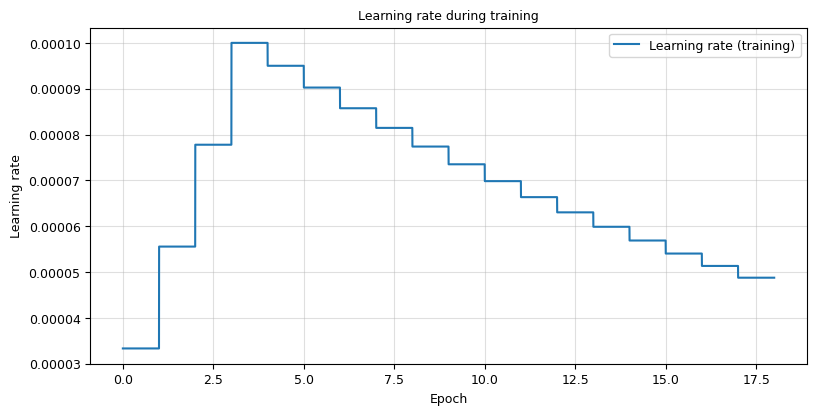

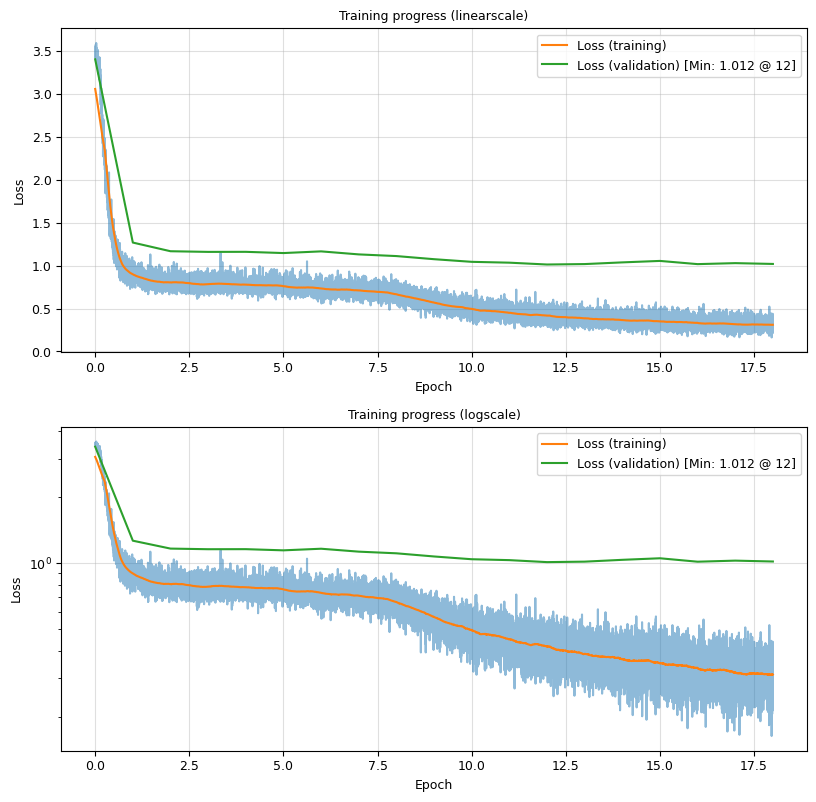

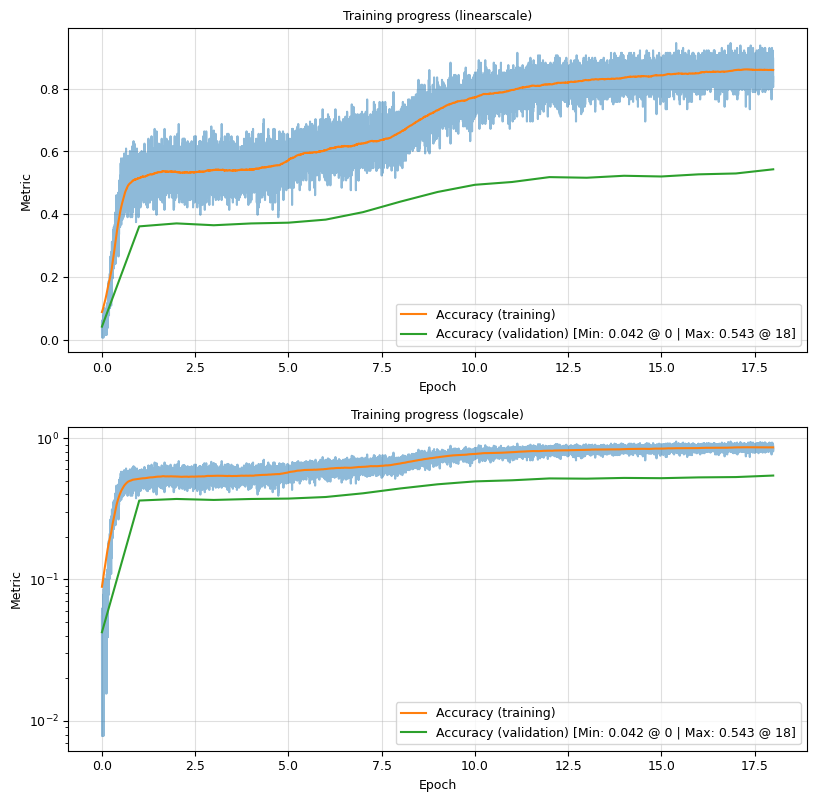

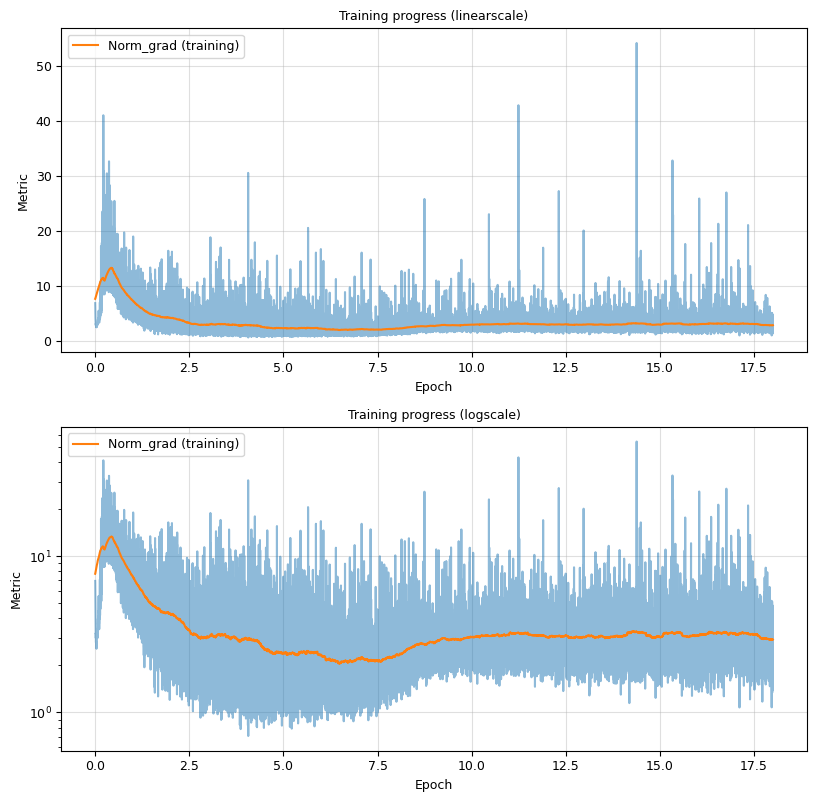

In [39]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "accuracy")
plot_metric(log, "norm_grad")

### Object encoder pretraining

In [38]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = ScanNet(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
)
dataset_validation = ScanNet(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

  0%|                                                                                                                                                                                                                                        | 0/1201 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 22.41it/s]


In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = GAEScan(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_encoder_gnn=NUMS_CHANNELS_HIDDEN_ENCODER_GNN,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    use_residual=USE_RESIDUAL,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

freeze(model.encoder_points)

criterion = SumWeighted(
    modules=(
        Select("degrees", torch.nn.MSELoss()),
        Select("features_points", torch.nn.MSELoss()),
        Select("features_class", torch.nn.MSELoss()),
        Select("positions", torch.nn.MSELoss()),
        Select("neighbors", Matching()),
    ),
    weights=CRITERION_WEIGHTS,
)
optimizer = torch.optim.Adam(model.parameters(), lr=RATE_LEARNING, weight_decay=RATE_DECAY_WEIGHT)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR_PRETRAINING),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        # In-degree for each node (same as out-degree since we use undirected edges anyway)
        target_degree = torch_geo.utils.degree(data["edge_index"][1], num_nodes=data.num_nodes)[:, None]
        target = dict(
            degrees=target_degree,
            features_points=output["features_points_raw"],
            features_class=data["embeddings_class"],
            positions=torch.cat((data["pos"], data["size"]), dim=1),
            neighbors=None,
        )

        loss = criterion(output, target)

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count

        if i % NUM_STEPS_LOGGING == 1 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        # In-degree for each node (same as out-degree since we use undirected edges anyway)
        target_degree = torch_geo.utils.degree(data["edge_index"][1], num_nodes=data.num_nodes)[:, None]
        target = dict(
            degrees=target_degree,
            features_points=output["features_points_raw"],
            features_class=data["embeddings_class"],
            positions=torch.cat((data["pos"], data["size"]), dim=1),
            neighbors=None,
        )

        loss = criterion(output, target)

        num_samples = data["ptr"].size(0) - 1
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr)

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count

        if i % NUM_STEPS_LOGGING == 1 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS_PRETRAINING + 1):
    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

        save(epoch, model, name="gae_best")

    save(epoch, model, name="gae_latest")

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING_PRETRAINING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 003 | LR 0.00003333 | Loss 43.83117: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.24s/it]
Training: Epoch 001 | Batch 010 | LR 0.00003333 | Loss 44.52050: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.48s/it]
Validation: Epoch 001 | Batch 003 | LR 0.00003333 | Loss 42.91863: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.15s/it]
Training: Epoch 002 | Batch 010 | LR 0.00005556 | Loss 39.36177: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Looping stopped early


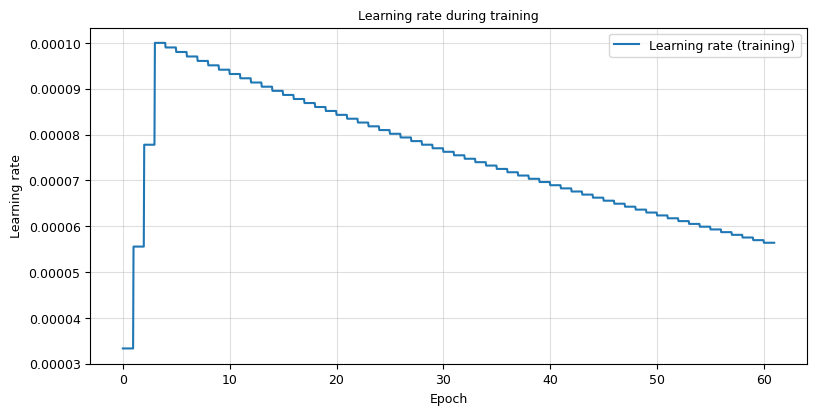

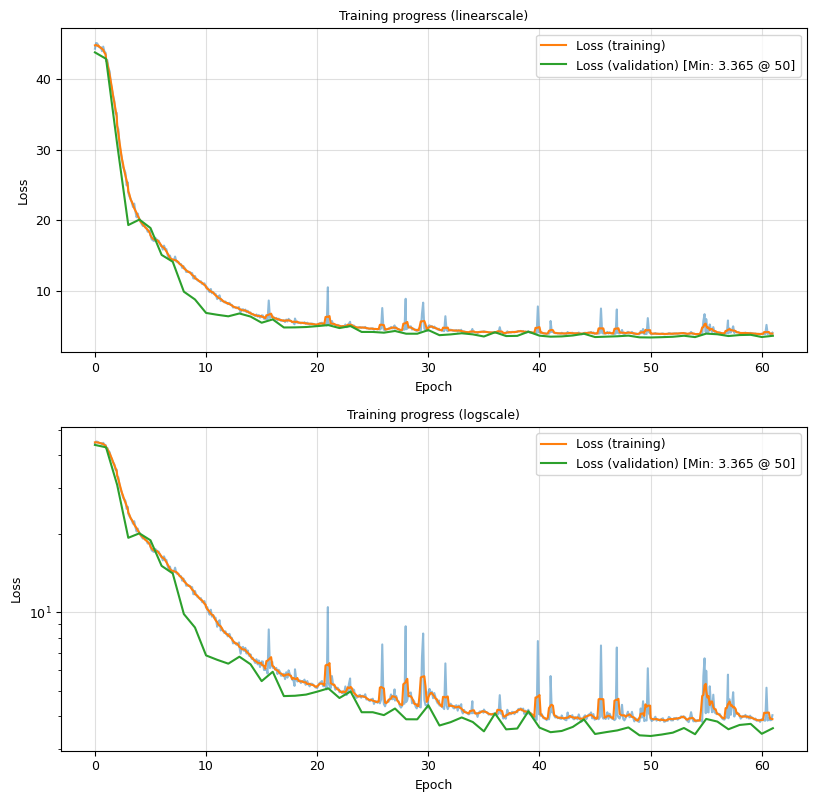

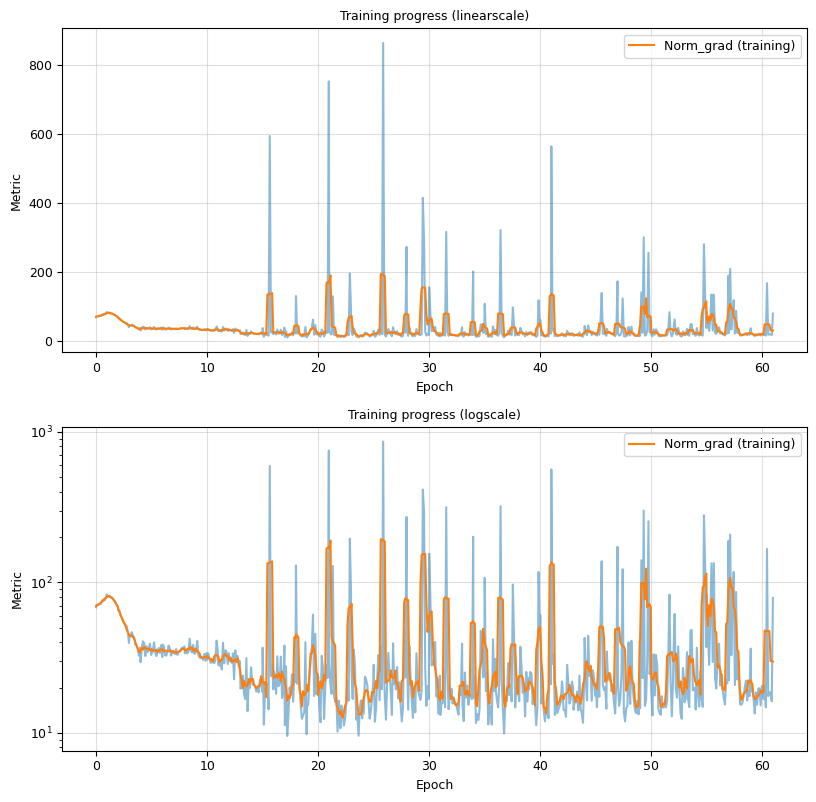

In [40]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "norm_grad")

### Visual Grounding (using pretrained object encoder)

In [38]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = NR3DReferral(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)
dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

  0%|                                                                                                                                                                                                                                        | 0/1201 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 22.60it/s]


In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ModelVisualGroundingGNN(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_encoder_gnn=NUMS_CHANNELS_HIDDEN_ENCODER_GNN,
    nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
    nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
    nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    num_layers_referral=NUM_LAYERS_REFERRAL,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    prob_dropout_head=PROB_DROPOUT_HEAD,
    prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
    prob_dropout_referral=PROB_DROPOUT_REFERRAL,
    use_residual=USE_RESIDUAL,
    use_concat=USE_CONCAT,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
    use_encoding_positions=USE_ENCODING_POSITIONS,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

path_weights_gnn = path_weights / "checkpoints" / "gae_best.pth"
checkpoint = torch.load(path_weights_gnn)
model.encoder_position.load_state_dict({k.replace("encoder_position.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("encoder_position.")})
model.encoder_fusion.load_state_dict({k.replace("encoder_fusion.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("encoder_fusion.")})
model.projector_class.load_state_dict({k.replace("projector_class.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("projector_class.")})
model.encoder_gnn.load_state_dict({k.replace("gae.encoder_gnn.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("gae.encoder_gnn.")})

freeze(model.encoder_points)
# freeze(model.encoder_language)
freeze(model.encoder_position)
freeze(model.encoder_fusion)
freeze(model.projector_class)
freeze(model.encoder_gnn)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{"params": [p for n, p in model.named_parameters() if "encoder_language" not in n]}, {"params": [p for n, p in model.named_parameters() if "encoder_language" in n], "lr": RATE_LEARNING * 0.1}],
    lr=RATE_LEARNING,
    betas=(BETA1, BETA2),
    weight_decay=RATE_DECAY_WEIGHT,
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, accuracy, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    log[pass_loop]["batches"]["metrics"]["accuracy"].append(accuracy)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    accuracies = np.asarray(log[pass_loop]["batches"]["metrics"]["accuracy"][-num_batches:])
    accuracy_epoch = np.sum(accuracies * nums_samples) / num_samples
    log[pass_loop]["epochs"]["metrics"]["accuracy"].append(accuracy_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, accuracy.item(), norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count
        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr, accuracy.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count

        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 059 | LR 0.00003333 | Loss 3.39816 | Accuracy 0.0428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.54it/s]
Training: Epoch 001 | Batch 931 | LR 0.00003333 | Loss 2.05181 | Accuracy 0.3062: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:21<00:00,  3.56it/s]
Validation: Epoch 001 | Batch 059 | LR 0.00003333 | Loss 1.57635 | Accuracy 0.3360: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.84it/s]
Training: Epoch 002 | Batch 931 | LR 0.00005556 | Loss 1.44295 | Accuracy 0.4381: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Looping stopped early


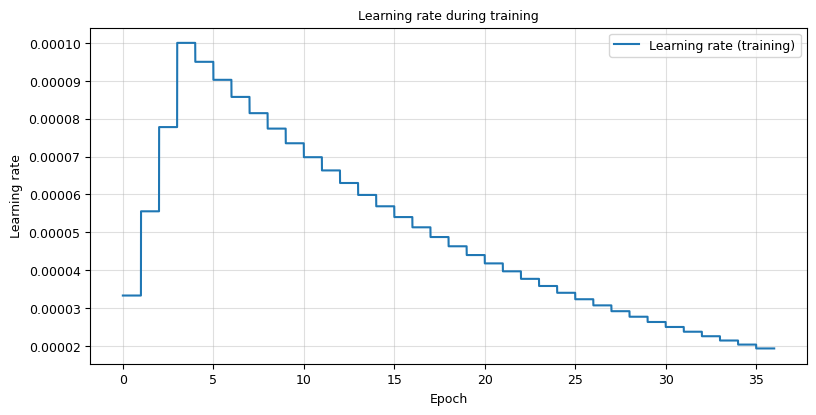

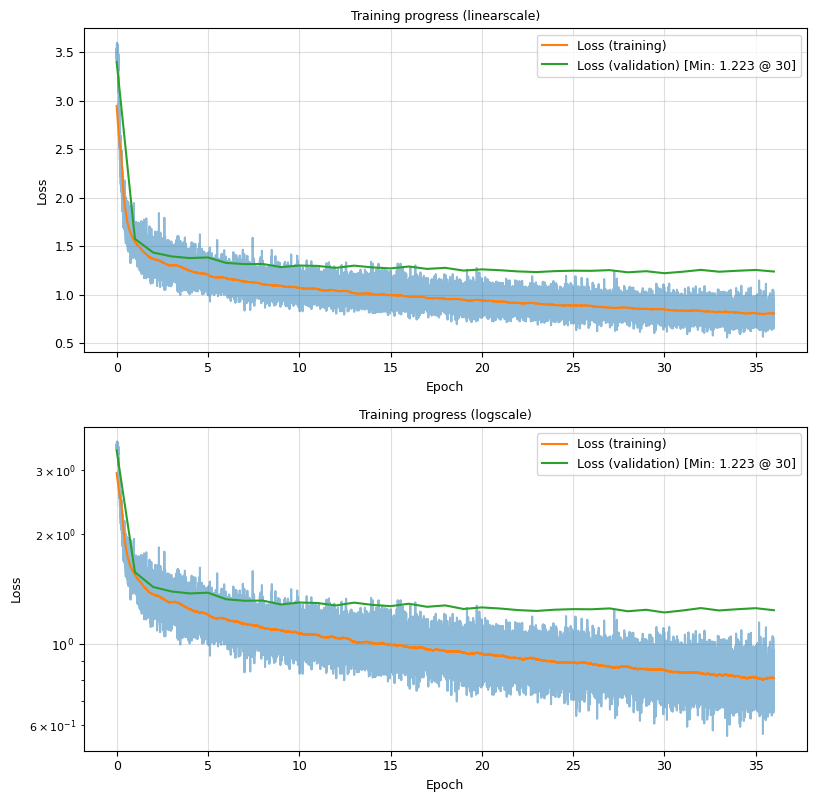

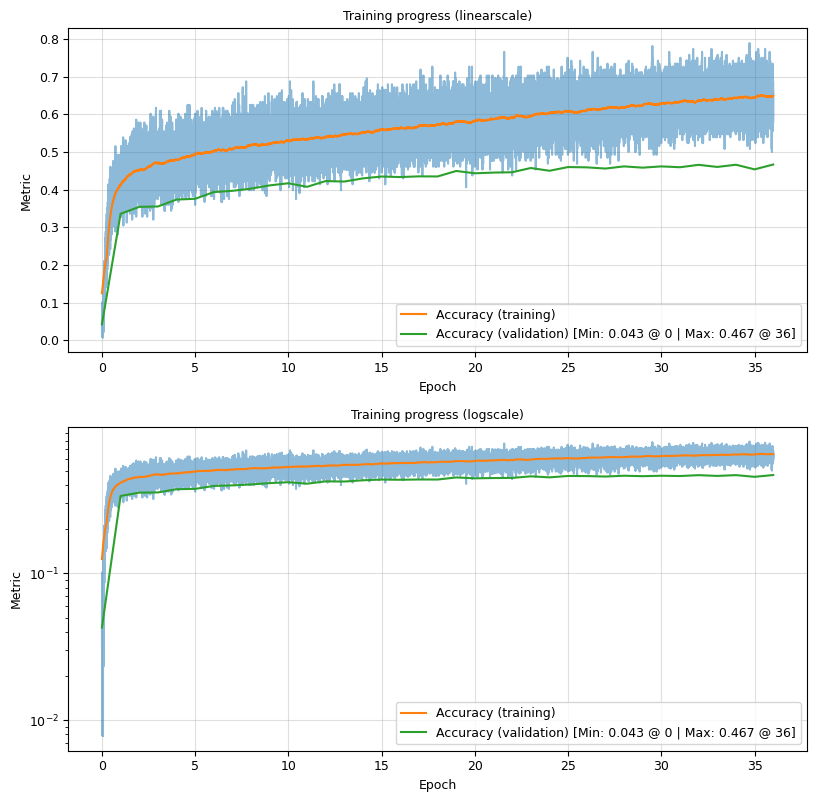

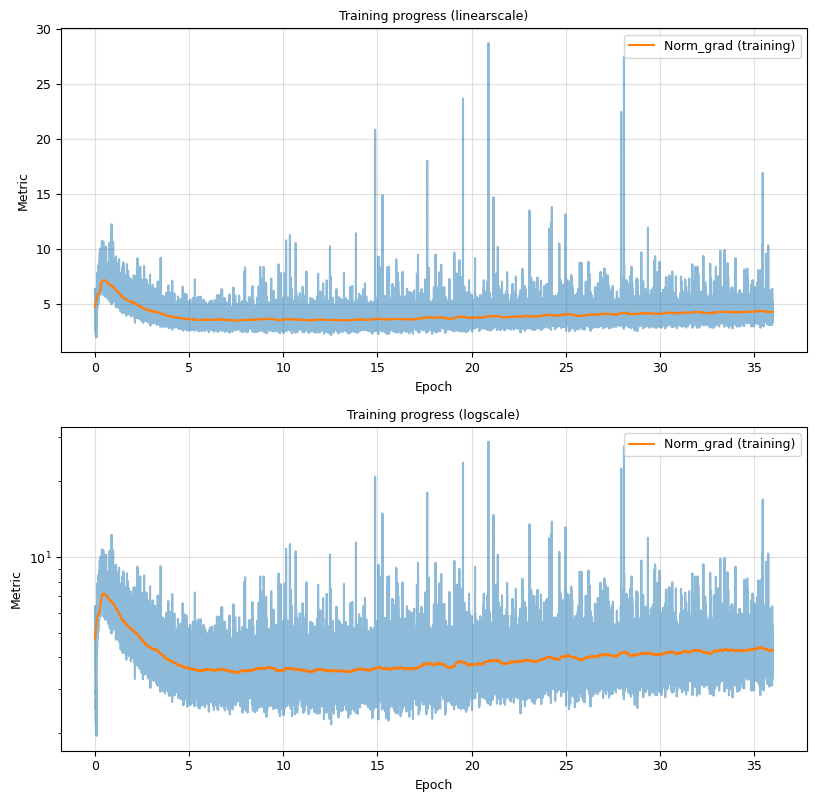

In [41]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "accuracy")
plot_metric(log, "norm_grad")

### Visual Grounding (using pretrained object encoder, unfreeze during training)

In [40]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = NR3DReferral(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)
dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

  0%|                                                                                                                                                                                                             | 0/1201 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 22.90it/s]


In [41]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ModelVisualGroundingGNN(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_encoder_gnn=NUMS_CHANNELS_HIDDEN_ENCODER_GNN,
    nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
    nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
    nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    num_layers_referral=NUM_LAYERS_REFERRAL,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    prob_dropout_head=PROB_DROPOUT_HEAD,
    prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
    prob_dropout_referral=PROB_DROPOUT_REFERRAL,
    use_residual=USE_RESIDUAL,
    use_concat=USE_CONCAT,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
    use_encoding_positions=USE_ENCODING_POSITIONS,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

path_weights_gnn = path_weights / "checkpoints" / "gae_best.pth"
checkpoint = torch.load(path_weights_gnn)
model.encoder_position.load_state_dict({k.replace("encoder_position.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("encoder_position.")})
model.encoder_fusion.load_state_dict({k.replace("encoder_fusion.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("encoder_fusion.")})
model.projector_class.load_state_dict({k.replace("projector_class.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("projector_class.")})
model.encoder_gnn.load_state_dict({k.replace("gae.encoder_gnn.", ""): v for k, v in checkpoint["state_dict_model"].items() if k.startswith("gae.encoder_gnn.")})

freeze(model.encoder_points)
# freeze(model.encoder_language)
freeze(model.encoder_position)
freeze(model.projector_class)
freeze(model.encoder_fusion)
freeze(model.encoder_gnn)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{"params": [p for n, p in model.named_parameters() if "encoder_language" not in n]}, {"params": [p for n, p in model.named_parameters() if "encoder_language" in n], "lr": RATE_LEARNING * 0.1}],
    lr=RATE_LEARNING,
    betas=(BETA1, BETA2),
    weight_decay=RATE_DECAY_WEIGHT,
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, accuracy, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    log[pass_loop]["batches"]["metrics"]["accuracy"].append(accuracy)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    accuracies = np.asarray(log[pass_loop]["batches"]["metrics"]["accuracy"][-num_batches:])
    accuracy_epoch = np.sum(accuracies * nums_samples) / num_samples
    log[pass_loop]["epochs"]["metrics"]["accuracy"].append(accuracy_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, accuracy.item(), norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count
        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr, accuracy.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count

        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS + 1):
    if epoch == 10:
        unfreeze(model.encoder_position)
        unfreeze(model.encoder_fusion)
        unfreeze(model.projector_class)
        unfreeze(model.encoder_gnn)

    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 059 | LR 0.00003333 | Loss 3.39816 | Accuracy 0.0428: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.54it/s]
Training: Epoch 001 | Batch 931 | LR 0.00003333 | Loss 2.05340 | Accuracy 0.3054: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:21<00:00,  3.56it/s]
Validation: Epoch 001 | Batch 059 | LR 0.00003333 | Loss 1.56673 | Accuracy 0.3353: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.76it/s]
Training: Epoch 002 | Batch 931 | LR 0.00005556 | Loss 1.44279 | Accuracy 0.4369: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:16<00:00,  3.63it/s]
Validation: Epoch 002 | Batch 059 | LR 0.00005556 | Loss

Looping stopped early


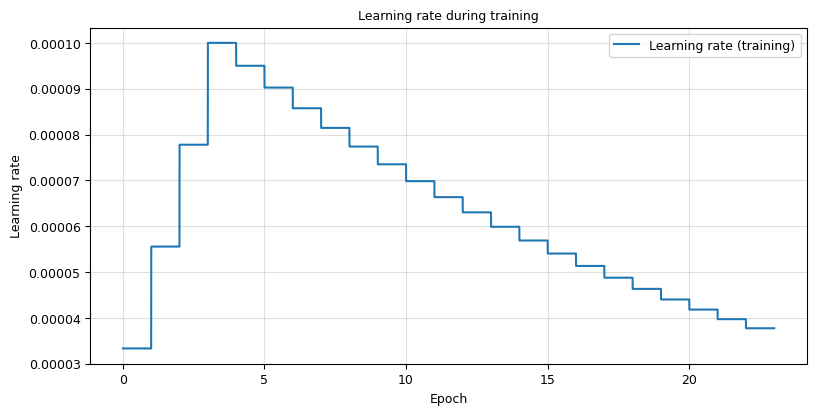

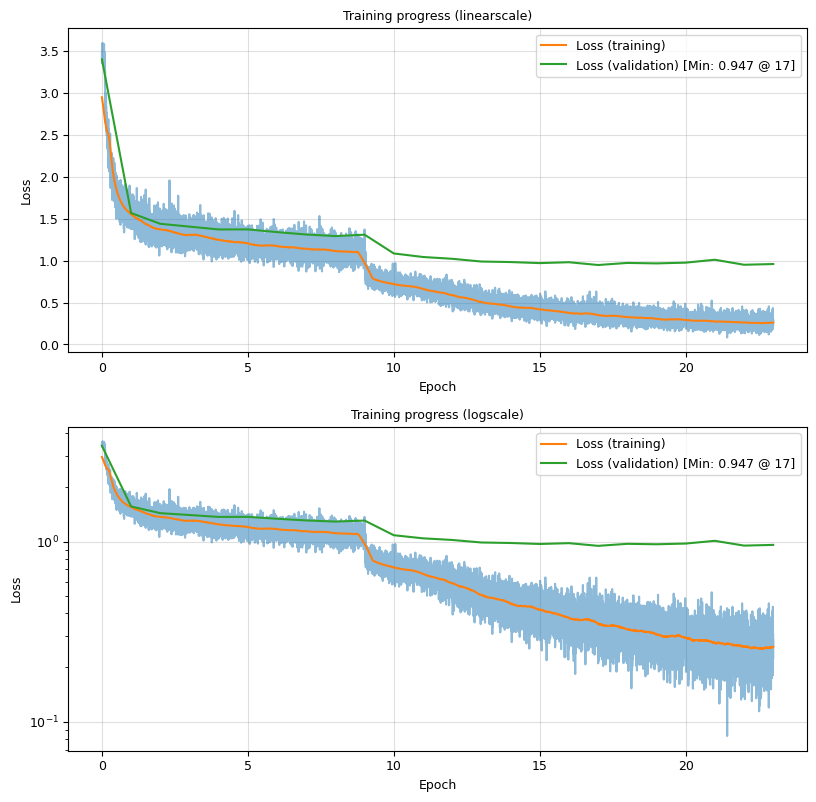

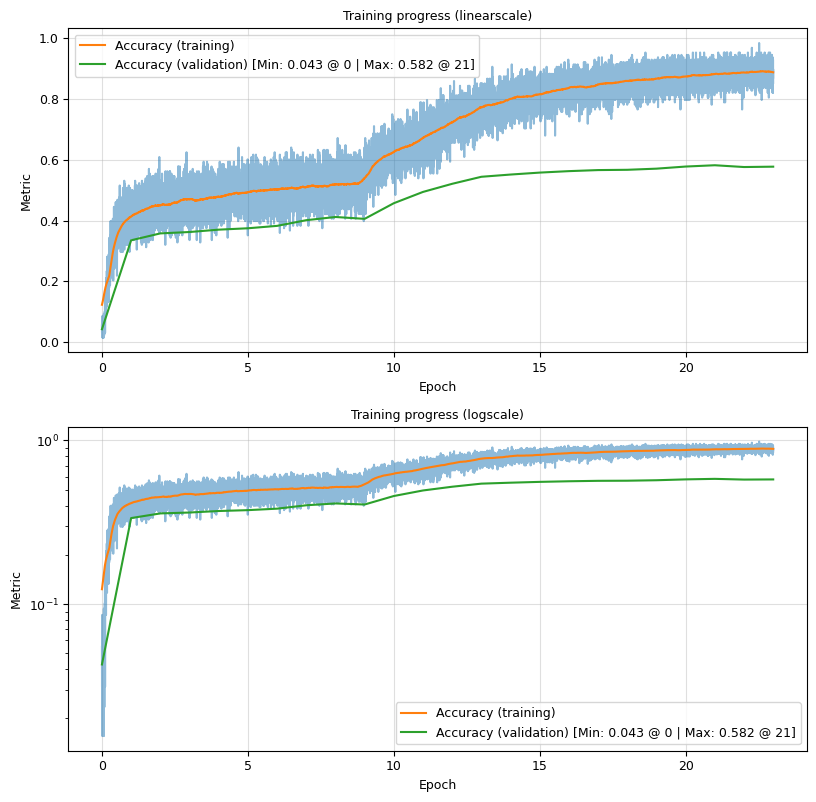

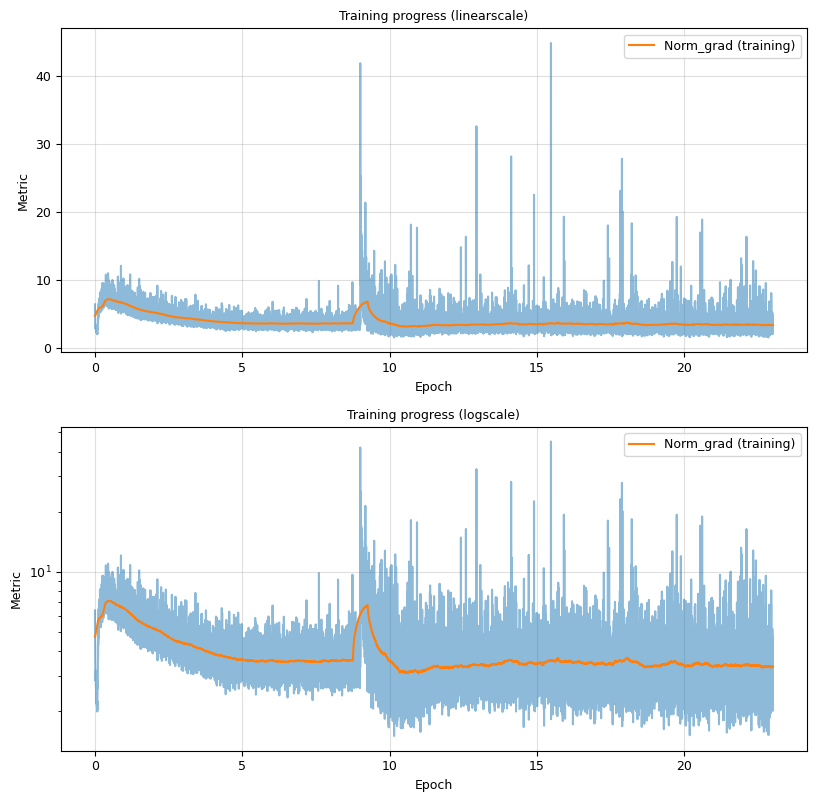

In [42]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "accuracy")
plot_metric(log, "norm_grad")

### Visual Grounding (spatial transformer instead of GNN)

In [37]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = NR3DReferral(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)
dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

  0%|                                                                                                                                                                                                                                        | 0/1201 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 23.50it/s]


In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ModelVisualGroundingSpatialTransformer(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
    nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
    nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    num_layers_referral=NUM_LAYERS_REFERRAL,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    prob_dropout_head=PROB_DROPOUT_HEAD,
    prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
    prob_dropout_referral=PROB_DROPOUT_REFERRAL,
    use_residual=USE_RESIDUAL,
    use_concat=USE_CONCAT,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
    use_encoding_positions=USE_ENCODING_POSITIONS,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

freeze(model.encoder_points)
# freeze(model.encoder_language)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{"params": [p for n, p in model.named_parameters() if "encoder_language" not in n]}, {"params": [p for n, p in model.named_parameters() if "encoder_language" in n], "lr": RATE_LEARNING * 0.1}],
    lr=RATE_LEARNING,
    betas=(BETA1, BETA2),
    weight_decay=RATE_DECAY_WEIGHT,
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, accuracy, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    log[pass_loop]["batches"]["metrics"]["accuracy"].append(accuracy)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    accuracies = np.asarray(log[pass_loop]["batches"]["metrics"]["accuracy"][-num_batches:])
    accuracy_epoch = np.sum(accuracies * nums_samples) / num_samples
    log[pass_loop]["epochs"]["metrics"]["accuracy"].append(accuracy_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, accuracy.item(), norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count
        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr, accuracy.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count

        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 059 | LR 0.00003333 | Loss 3.39571 | Accuracy 0.0454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.59it/s]
Training: Epoch 001 | Batch 931 | LR 0.00003333 | Loss 2.03965 | Accuracy 0.2669: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [05:00<00:00,  3.09it/s]
Validation: Epoch 001 | Batch 059 | LR 0.00003333 | Loss 1.35038 | Accuracy 0.3454: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.71it/s]
Training: Epoch 002 | Batch 931 | LR 0.00005556 | Loss 0.95361 | Accuracy 0.4935: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Looping stopped early


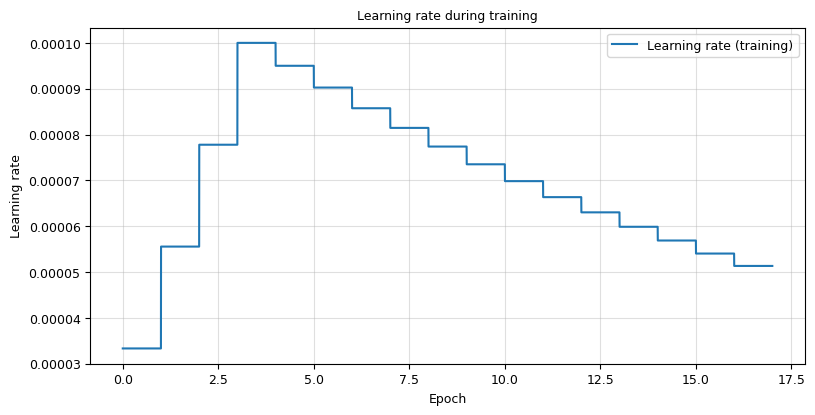

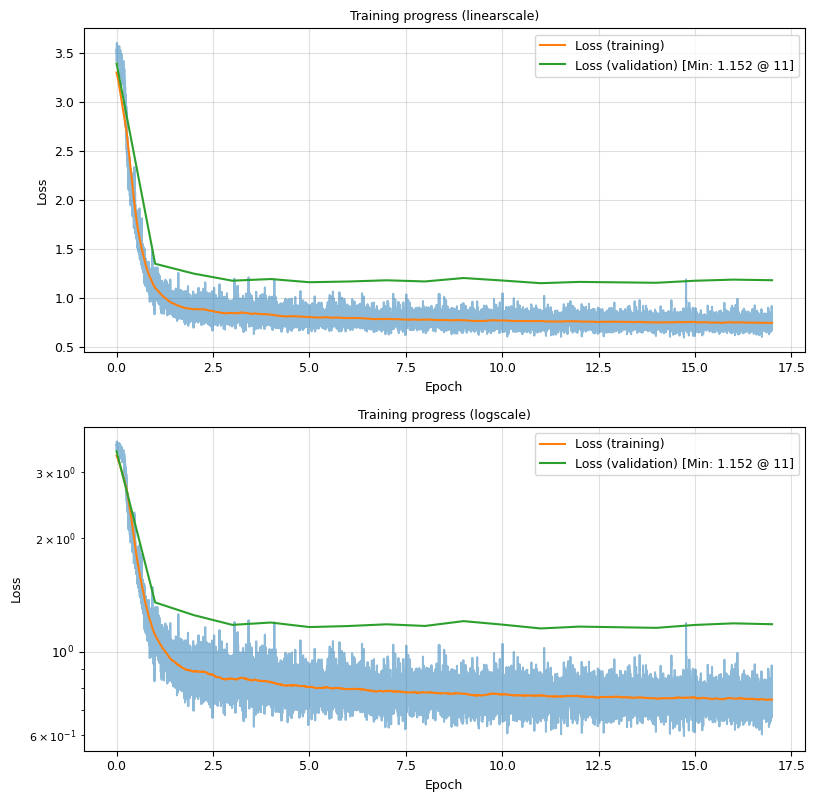

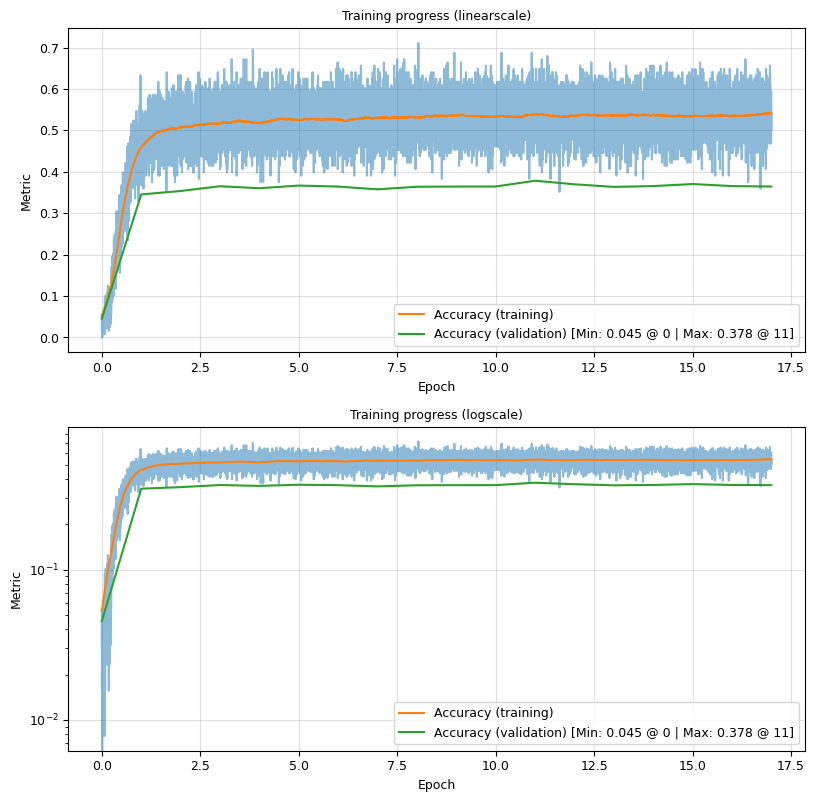

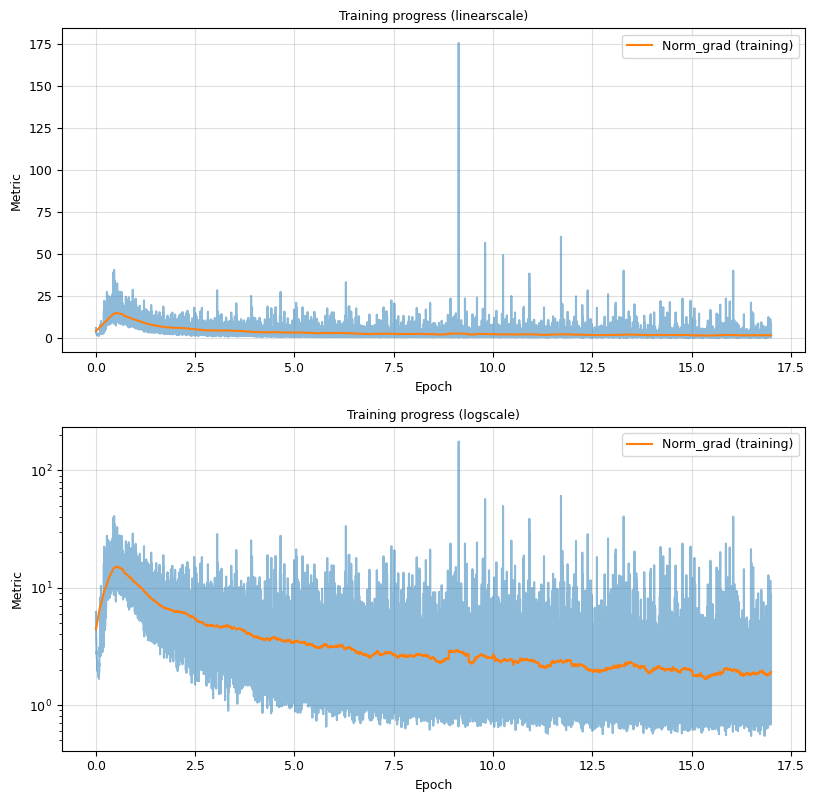

In [39]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "accuracy")
plot_metric(log, "norm_grad")

### Visual Grounding (without GNN)

In [38]:
transforms_points_training = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    RotationScan(prob=PROB_AUGMENTATION_ROTATION_SCENE, use_axis_z=USE_AXIS_Z, use_axis_alignment=USE_AXIS_ALIGNMENT),
    RotationObjects(prob=PROB_AUGMENTATION_ROTATION_OBJECTS),
    TranslationObjectsScan(prob=PROB_AUGMENTATION_TRANSLATION_OBJECTS, scale=SCALE_TRANSLATION_OBJECTS),
    ColorJitterScan(prob=PROB_AUGMENTATION_JITTER_COLOR, scale=SCALE_JITTER_COLOR),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]
transforms_points_validation = [
    PointsToTensorScanSubsample(num_points=NUM_POINTS_SUBSAMPLE),
    CreateBoxesScanAxisAligned(),
    PointsCenterScan(),
    PointsNormalizeScaleScan(),
]

transform_training = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)
transform_validation = torch_geo.transforms.Compose(
    [
        torch_geo.transforms.ToUndirected(),
        torch_geo.transforms.Center(),
        torch_geo.transforms.NormalizeScale(),
        # torch_geo.transforms.NormalizeRotation(),
    ]
)

dataset_training = NR3DReferral(
    path=path_dataset,
    split="training",
    transform=transform_training,
    transforms_points=transforms_points_training,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)
dataset_validation = NR3DReferral(
    path=path_dataset,
    split="validation",
    transform=transform_validation,
    transforms_points=transforms_points_validation,
    use_background=USE_BACKGROUND,
    max_distance=MAX_DISTANCE,
    num_neighbors=NUM_NEIGHBORS,
    use_sr3d_plus=True,
)

dataloader_training = torch_geo.loader.DataLoader(
    dataset_training,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=True,
)
dataloader_validation = torch_geo.loader.DataLoader(
    dataset_validation,
    batch_size=NUM_ITEMS_BATCH,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    shuffle=False,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:13<00:00, 23.11it/s]


In [39]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = ModelVisualGrounding(
    num_channels_in=NUM_CHANNELS_IN,
    num_channels_hidden=NUM_CHANNELS_HIDDEN,
    nums_channels_hidden_encoder_position=NUMS_CHANNELS_HIDDEN_ENCODER_POSITION,
    num_channels_out_encoder_position=NUMS_CHANNELS_OUT_ENCODER_POSITION,
    nums_channels_hidden_projector_class=NUMS_CHANNELS_HIDDEN_PROJECTOR_CLASS,
    num_channels_out_projector_class=NUMS_CHANNELS_OUT_PROJECTOR_CLASS,
    nums_channels_hidden_projector_language=NUMS_CHANNELS_HIDDEN_PROJECTOR_LANGUAGE,
    nums_channels_hidden_referral=NUMS_CHANNELS_HIDDEN_REFFERAL,
    nums_channels_hidden_head=NUMS_CHANNELS_HIDDEN_HEAD,
    num_samples=NUM_SAMPLES_NEIGHBORS,
    num_layers_referral=NUM_LAYERS_REFERRAL,
    name_layer_conv=NAME_LAYER_CONV,
    mode_norm="PN-SCS",
    scale_norm=20,
    prob_dropout_encoder_points=PROB_DROPOUT_ENCODER_POINTS,
    prob_dropout_projector_class=PROB_DROPOUT_PROJECTOR_CLASS,
    prob_dropout_encoder_gnn=PROB_DROPOUT_ENCODER_GNN,
    prob_dropout_encoder_position=PROB_DROPOUT_ENCODER_POSITION,
    prob_dropout_head=PROB_DROPOUT_HEAD,
    prob_dropout_projector_language=PROB_DROPOUT_PROJECTOR_LANGUAGE,
    prob_dropout_referral=PROB_DROPOUT_REFERRAL,
    use_residual=USE_RESIDUAL,
    use_concat=USE_CONCAT,
    mode_jk=MODE_JK,
    use_norm_pair=USE_NORM_PAIR,
    use_encoding_positions=USE_ENCODING_POSITIONS,
)

path_weights = Path(PATH_DIR_WEIGHTS)
path_weights_pointnet = path_weights / "pointnet_tokenizer.pth"
model.encoder_points.load_weights(path_weights_pointnet)

freeze(model.encoder_points)
# freeze(model.encoder_language)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    [{"params": [p for n, p in model.named_parameters() if "encoder_language" not in n]}, {"params": [p for n, p in model.named_parameters() if "encoder_language" in n], "lr": RATE_LEARNING * 0.1}],
    lr=RATE_LEARNING,
    betas=(BETA1, BETA2),
    weight_decay=RATE_DECAY_WEIGHT,
)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    schedulers=[
        torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0 / NUM_EPOCHS_WARMUP, end_factor=1.0, total_iters=NUM_EPOCHS_WARMUP),
        torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA_DECAY_LR),
    ],
    milestones=[NUM_EPOCHS_WARMUP],
)

log = {
    "training": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
    "validation": {
        "batches": {
            "epoch": [],
            "num_samples": [],
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
        "epochs": {
            "learning_rate": [],
            "loss": [],
            "metrics": collections.defaultdict(list),
        },
    },
}


@torch.no_grad()
def log_batch(pass_loop, epoch, num_samples, loss, lr, accuracy, norm_grad=None):
    log[pass_loop]["batches"]["epoch"].append(epoch)
    log[pass_loop]["batches"]["num_samples"].append(num_samples)
    log[pass_loop]["batches"]["loss"].append(loss)
    log[pass_loop]["batches"]["learning_rate"].append(lr)
    log[pass_loop]["batches"]["metrics"]["accuracy"].append(accuracy)
    if pass_loop == "training":
        log[pass_loop]["batches"]["metrics"]["norm_grad"].append(norm_grad)


@torch.no_grad()
def log_epoch(pass_loop, num_samples, num_batches):
    nums_samples = np.asarray(log[pass_loop]["batches"]["num_samples"][-num_batches:])

    losses = np.asarray(log[pass_loop]["batches"]["loss"][-num_batches:])
    loss_epoch = np.sum(losses * nums_samples) / num_samples
    log[pass_loop]["epochs"]["loss"].append(loss_epoch)

    lrs = np.asarray(log[pass_loop]["batches"]["learning_rate"][-num_batches:])
    lr_epoch = np.sum(lrs * nums_samples) / num_samples
    log[pass_loop]["epochs"]["learning_rate"].append(lr_epoch)

    accuracies = np.asarray(log[pass_loop]["batches"]["metrics"]["accuracy"][-num_batches:])
    accuracy_epoch = np.sum(accuracies * nums_samples) / num_samples
    log[pass_loop]["epochs"]["metrics"]["accuracy"].append(accuracy_epoch)

    if pass_loop == "training":
        norms_grad = np.asarray(log[pass_loop]["batches"]["metrics"]["norm_grad"][-num_batches:])
        norm_grad_epoch = np.sum(norms_grad * nums_samples) / num_samples
        log[pass_loop]["epochs"]["metrics"]["norm_grad"].append(norm_grad_epoch)


def train_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_training, total=len(dataloader_training))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        loss.backward()
        if USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM_GRAD)
        optimizer.step()

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        if not USE_CLIP_GRAD:
            norm_grad = torch.nn.utils.get_total_norm([p.grad for p in model.parameters() if p.grad is not None])
        log_batch("training", epoch, num_samples, loss.item(), lr, accuracy.item(), norm_grad.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count
        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_training):
            progress_bar.set_description(f"Training: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("training", len(dataset_training), len(dataloader_training))


@torch.no_grad()
def validate_epoch(epoch):
    loss_total = 0.0
    correct_total = 0
    count = 0
    progress_bar = tqdm(dataloader_validation, total=len(dataloader_validation))
    for i, data in enumerate(progress_bar, start=1):
        data = data.to(device)

        output = model(data)

        loss = criterion(output["logits"], data["idx_target"])

        num_samples = data["ptr"].size(0) - 1
        preds = output["logits"].max(1)[1].type_as(data["idx_target"])
        correct = torch.sum(preds.detach().eq(data["idx_target"]).double())
        accuracy = correct / num_samples
        lr = optimizer.param_groups[0]["lr"]
        log_batch("validation", epoch, num_samples, loss.item(), lr, accuracy.item())

        count += num_samples
        loss_total += loss.item() * num_samples
        loss_epoch = loss_total / count
        correct_total += correct
        accuracy_epoch = correct_total / count

        if i == 1 or i % NUM_STEPS_LOGGING == 0 or i == len(dataloader_validation):
            progress_bar.set_description(f"Validation: Epoch {epoch:03d} | Batch {i:03d} | LR {lr:.8f} | Loss {loss_epoch:.5f} | Accuracy {accuracy_epoch:.4f}")

    log_epoch("validation", len(dataset_validation), len(dataloader_validation))


model = model.to(device)
criterion = criterion.to(device)

loss_best = float("inf")
epoch_loss_best = 0
validate_epoch(0)
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_epoch(epoch)

    model.eval()
    validate_epoch(epoch)

    loss_epoch = log["validation"]["epochs"]["loss"][-1]
    if scheduler is not None:
        scheduler.step()

    if loss_epoch < loss_best:
        loss_best = loss_epoch
        epoch_loss_best = epoch

    if USE_EARLY_STOPPING and epoch - epoch_loss_best > PATIENCE_EARLY_STOPPING:
        print("Looping stopped early")
        break


model = model.cpu()
criterion = criterion.cpu()

Validation: Epoch 000 | Batch 059 | LR 0.00003333 | Loss 3.40058 | Accuracy 0.0432: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:16<00:00,  3.60it/s]
Training: Epoch 001 | Batch 931 | LR 0.00003333 | Loss 1.56802 | Accuracy 0.3849: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:22<00:00,  3.55it/s]
Validation: Epoch 001 | Batch 059 | LR 0.00003333 | Loss 1.24119 | Accuracy 0.3686: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:15<00:00,  3.74it/s]
Training: Epoch 002 | Batch 931 | LR 0.00005556 | Loss 0.81756 | Accuracy 0.5314: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [04:16<00:00,  3.63it/s]
Validation: Epoch 002 | Batch 059 | LR 0.00005556 | Loss

Looping stopped early


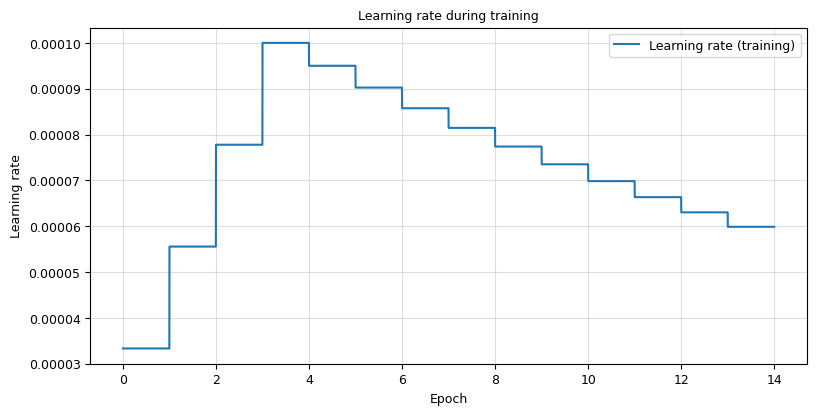

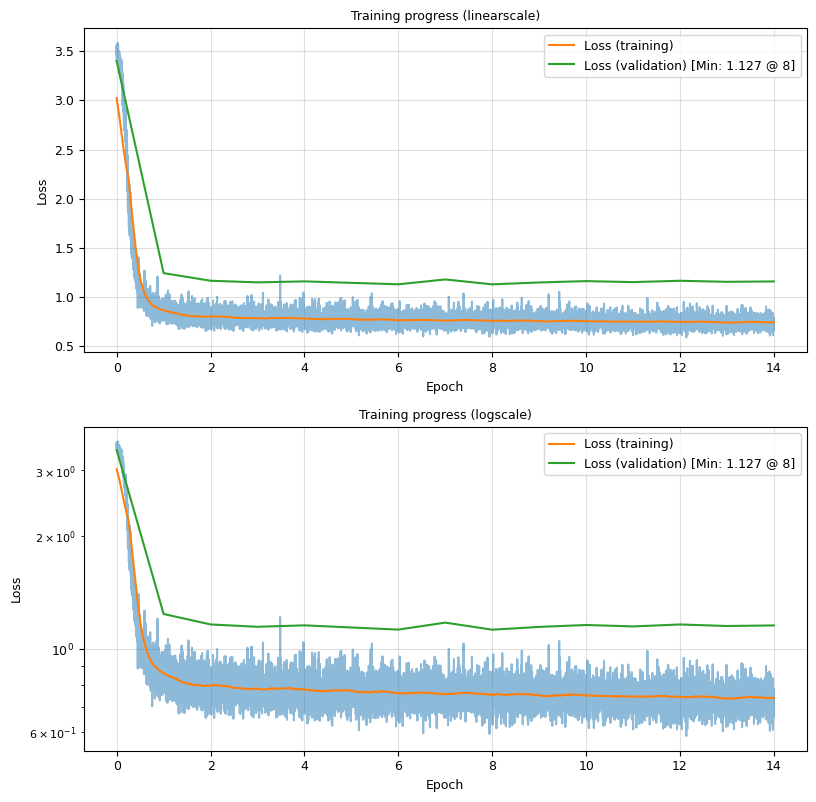

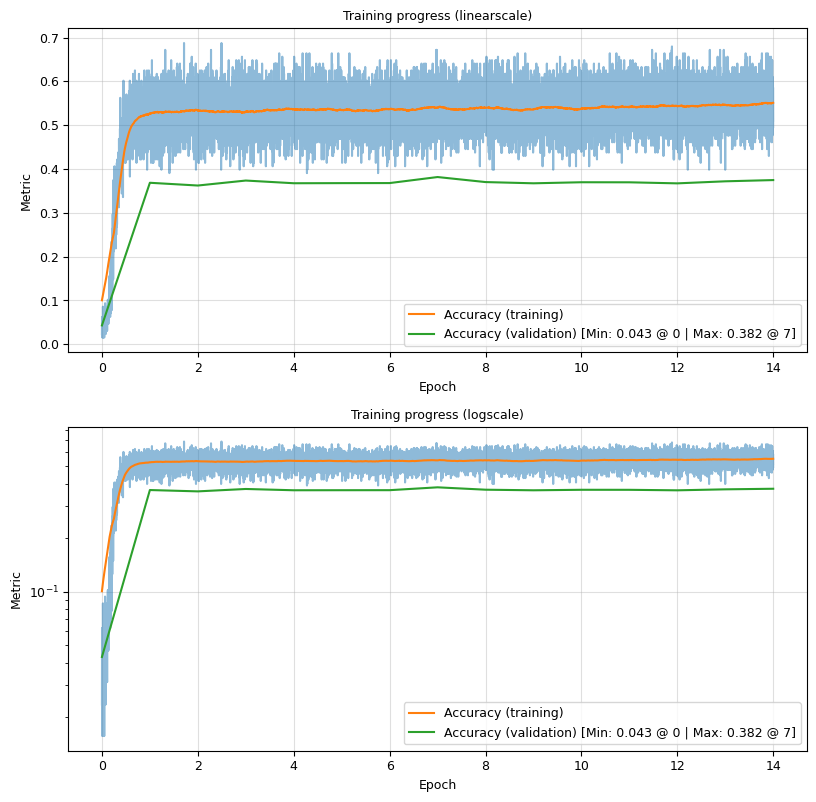

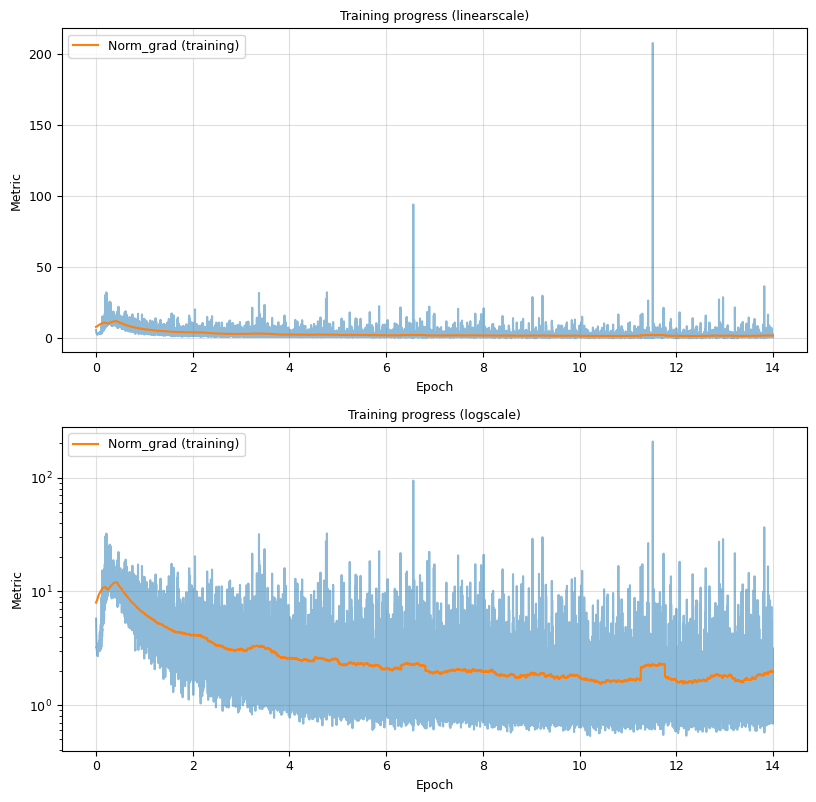

In [40]:
plot_learning_rate(log)
plot_loss(log)
plot_metric(log, "accuracy")
plot_metric(log, "norm_grad")